In [2]:
!pip install shap

In [28]:
# @title Importing Libraries
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay

# Preprocessing and Data Splitting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Traditional Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Boosting Models
import xgboost as xgb
import lightgbm as lgb

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Deep Learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import R2Score

# explainable ai
import shap


In [29]:
# @title Defining Classes

# dataloader class

class DFTDataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.sheet_names = pd.ExcelFile(file_path).sheet_names

    def load_combined_data(self):
        all_data = []
        for sheet in self.sheet_names:
            df = pd.read_excel(self.file_path, sheet_name=sheet)
            df["Strain (%)"] = float(sheet.strip('%'))  # Extract strain from sheet name
            all_data.append(df)
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df

# preprocessing class

class DataPreprocessor:
    def __init__(self):
        self.input_scaler = StandardScaler()
        self.output_scaler = StandardScaler()

    # def preprocess(self, df):
    #     X = df[["Strain (%)", "hv (eV)", "epsilon real", "epsilon img"]].values
    #     y = df[["alpha (cm^-1)"]].values

    #     X_scaled = self.input_scaler.fit_transform(X)
    #     y_scaled = self.output_scaler.fit_transform(y)

    #     return X_scaled, y_scaled, X, y

    def preprocess(self, df):
        feature_cols = ["Strain (%)", "hv (eV)", "epsilon real", "epsilon img"]
        target_col = ["alpha (cm^-1)"]

        X = df[feature_cols]
        y = df[target_col]

        X_scaled = pd.DataFrame(self.input_scaler.fit_transform(X), columns=feature_cols)
        y_scaled = pd.DataFrame(self.output_scaler.fit_transform(y), columns=target_col)

        return X_scaled, y_scaled, X, y



# declaration of ML models

ml_models = {}

# Linear Regression
ml_models['LinearRegression'] = LinearRegression()

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
ml_models['RandomForest'] = GridSearchCV(rf, rf_params, cv=3)

# SVR
svr = SVR()
svr_params = {'C': [1, 10], 'epsilon': [0.1, 0.2]}
ml_models['SVR'] = GridSearchCV(svr, svr_params, cv=3)

# KNN
knn = KNeighborsRegressor()
knn_params = {'n_neighbors': [3, 5, 7]}
ml_models['KNN'] = GridSearchCV(knn, knn_params, cv=3)

# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42, verbosity=0)
xgb_params = {'n_estimators': [100], 'max_depth': [3, 6]}
ml_models['XGBoost'] = GridSearchCV(xgb_model, xgb_params, cv=3)

# LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_params = {'n_estimators': [100], 'num_leaves': [31, 63]}
ml_models['LightGBM'] = GridSearchCV(lgb_model, lgb_params, cv=3)


# Evalutation function for ML models

def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MSE = {mse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")

In [30]:
class DataPreprocessor:
    def __init__(self):
        self.input_scaler = StandardScaler()
        self.output_scaler = StandardScaler()
        self.feature_cols = ["Strain (%)", "hv (eV)", "epsilon real", "epsilon img"]
        self.target_col = ["alpha (cm^-1)"]

    def preprocess(self, df):
        X = df[self.feature_cols]
        y = df[self.target_col]

        X_scaled = pd.DataFrame(
            self.input_scaler.fit_transform(X),
            columns=self.feature_cols
        )
        y_scaled = pd.DataFrame(
            self.output_scaler.fit_transform(y),
            columns=self.target_col
        )

        return X_scaled, y_scaled, X, y


In [31]:
# @title NN model

def build_nn_model():
    nn_model = models.Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Single output: alpha
    ])
    nn_model.compile(optimizer='adam', loss='mse', metrics=['mae', R2Score()])
    return nn_model

In [32]:
# @title Step ML1: Load and Combine Data
# Set file path in Colab
file_path = "/content/DFT_ML_Parallel.xlsx"

# Load data
loader = DFTDataLoader(file_path)
df = loader.load_combined_data()
features = df.columns[:-1]
target = df.columns[-1]

# View first few rows
print(df)


       Strain (%)    hv (eV)  epsilon real  epsilon img  alpha (cm^-1)
0            -6.0   0.010000      4.148223          0.0            0.0
1            -6.0   0.027210      4.148489          0.0            0.0
2            -6.0   0.044421      4.149008          0.0            0.0
3            -6.0   0.061631      4.149778          0.0            0.0
4            -6.0   0.078841      4.150800          0.0            0.0
...           ...        ...           ...          ...            ...
13995         6.0  34.344510      0.925757          0.0            0.0
13996         6.0  34.361721      0.925840          0.0            0.0
13997         6.0  34.378931      0.925924          0.0            0.0
13998         6.0  34.396141      0.926007          0.0            0.0
13999         6.0  34.413352      0.926090          0.0            0.0

[14000 rows x 5 columns]


In [33]:
# @title Step ML2: Preprocessing and Normalization
# Apply preprocessing
preprocessor = DataPreprocessor()
X_scaled, y_scaled, X_raw, y_raw = preprocessor.preprocess(df)

print("Scaled Input Sample:", X_scaled[:2])
print("Scaled Target Sample:", y_scaled[:2])


Scaled Input Sample:    Strain (%)   hv (eV)  epsilon real  epsilon img
0        -1.5 -1.731185      2.447072    -0.503345
1        -1.5 -1.729453      2.447283    -0.503345
Scaled Target Sample:    alpha (cm^-1)
0      -0.721077
1      -0.721077


In [34]:
# @title Step ML3: Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


In [35]:
# @title Step ML4: ML Models Training
# Fit models
fitted_models = {}
for name, model in ml_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train.values.ravel())
    fitted_models[name] = model


Training LinearRegression...
Training RandomForest...
Training SVR...
Training KNN...
Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 7466, number of used features: 4
[LightGBM] [Info] Start training from score -0.003786
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 7467, number of used features: 4
[LightGBM] [Info] Start training from score -0.002954
[LightGBM] [Warning] Found whites

In [36]:
# @title Step ML5: Evaluation

for name, model in fitted_models.items():
    evaluate_model(name, model)


LinearRegression: MSE = 0.2522, MAE = 0.3616, R2 = 0.7489
RandomForest: MSE = 0.0038, MAE = 0.0261, R2 = 0.9962
SVR: MSE = 0.0032, MAE = 0.0469, R2 = 0.9969
KNN: MSE = 0.0076, MAE = 0.0238, R2 = 0.9925
XGBoost: MSE = 0.0010, MAE = 0.0147, R2 = 0.9990
LightGBM: MSE = 0.0009, MAE = 0.0140, R2 = 0.9991


Comparison of best ML prediction of alpha:    Predicted α (cm^-1)  Actual α (cm^-1)
0         47617.541930      46356.294755
1          1429.088080       1294.223234
2         15097.885819      15324.037696
3           202.393077        226.480560
4           -24.331934          0.010434
5           331.321214        352.145215
6         78628.953620      79414.667645
7            89.894740         71.456331
8         67148.969092      66416.392892
9           160.276603        169.912138


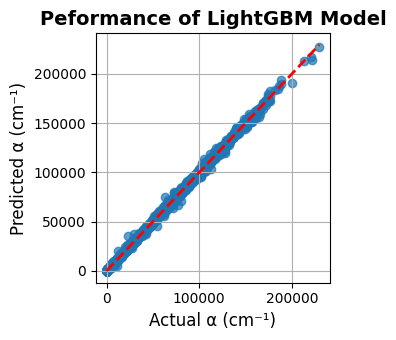

In [14]:
# @title Step ML6: Predict Alpha for Test Set for the best ML Model

# Use the same preprocessor and trained model as before
best_model = fitted_models["LightGBM"]

# Predict using scaled test set
alpha_test_scaled_pred = best_model.predict(X_test)

# Inverse transform to get predictions in original scale
alpha_test_pred = preprocessor.output_scaler.inverse_transform(alpha_test_scaled_pred.reshape(-1, 1))
alpha_test_true = preprocessor.output_scaler.inverse_transform(y_test.values.reshape(-1, 1))

# Display a few prediction vs actual values


comparison_df = pd.DataFrame({
    "Predicted α (cm^-1)": alpha_test_pred.flatten(),
    "Actual α (cm^-1)": alpha_test_true.flatten()
})


print(f"Comparison of best ML prediction of alpha: {comparison_df.head(10)}")

# plot the final predicted vs actual results

plt.figure(figsize=(3.5, 3.5))

# Set font type and sizes
font_properties = {'family': 'sans-serif', 'size': 12}  # or 'sans-serif', 'monospace', etc.

plt.scatter(alpha_test_true, alpha_test_pred, alpha=0.7)

# Increase line width of the red dashed diagonal
plt.plot(
    [min(alpha_test_true), max(alpha_test_true)],
    [min(alpha_test_true), max(alpha_test_true)],
    'r--', linewidth=2.0  # Line width here
)

plt.xlabel("Actual α (cm⁻¹)", fontdict=font_properties)
plt.ylabel("Predicted α (cm⁻¹)", fontdict=font_properties)
plt.title("Peformance of LightGBM Model", fontdict={'family': 'sans-serif', 'size': 14, 'weight': 'bold'})

plt.grid(True)
plt.tight_layout()

# Save figure in high resolution
plt.savefig("best_ML_predicted_vs_actual_alpha.png", dpi=600, bbox_inches='tight')
plt.show()



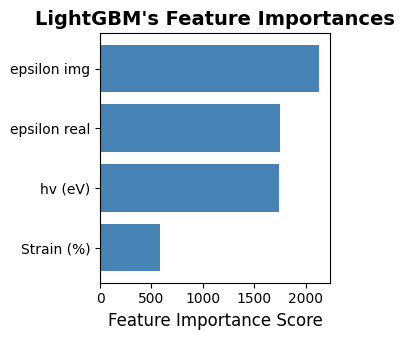

In [20]:
# @title Step ML7: Feature Importance according to best ML Model
# Choose best fitted tree model (replace 'XGBoost' with the best one)
best_model = fitted_models['LightGBM'].best_estimator_

# Plot feature importances
feature_importance = best_model.feature_importances_
# features = features
features = X_test.columns.tolist()

# plot and save
# Set font type and sizes
font_properties = {'family': 'sans-serif', 'size': 12}  # or 'sans-serif', 'monospace', etc.

plt.figure(figsize=(3.5, 3.5))
plt.barh(features, feature_importance, color='steelblue')
plt.xlabel('Feature Importance Score', fontdict=font_properties)
plt.title("LightGBM's Feature Importances", fontdict={'family': 'sans-serif', 'size': 14, 'weight': 'bold'})
plt.tight_layout()

# Save figure in high resolution
plt.savefig("best_ML_feature_importance.png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
# @title Step ML8: PDP Plot for best ML Model
# Choose any 1 or 2 features for interpretability (e.g., 'hv (eV)', 'epsilon img') ["Strain (%)", "hv (eV)", "epsilon real", "epsilon img"]
# Define your features
features_to_plot = ["Strain (%)", "hv (eV)", "epsilon real", "epsilon img"]

# Get the original estimator (not the GridSearchCV wrapper)
original_model = fitted_models['LightGBM'].best_estimator_

# Create 2x2 subplot
fig, ax = plt.subplots(2, 2, figsize=(3.5, 3.5))
# Set font type and sizes
font_properties = {'family': 'sans-serif', 'size': 12}  # or 'sans-serif', 'monospace', etc.

# Plot PDP with specified axes
PartialDependenceDisplay.from_estimator(
    original_model,
    X_test,  # This must be a DataFrame with original column names
    features_to_plot,
    kind='average',
    grid_resolution=50,
    ax=ax
)
# Remove individual y-labels
for ax_row in ax:
    for ax_single in ax_row:
        ax_single.set_ylabel('')
# Set the title and layout
fig.text(-0.01, 0.5, 'Partial Dependence', va='center', rotation='vertical', fontdict=font_properties)
plt.suptitle('Partial Dependence for LightGBM', family='sans-serif',
    fontsize=14,
    fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for suptitle
plt.savefig("ML_model_pdp_plot.png", dpi=600, bbox_inches='tight')
plt.show()



Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2542 - mae: 0.2976 - r2_score: 0.7522 - val_loss: 0.0751 - val_mae: 0.1066 - val_r2_score: 0.9199
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0612 - mae: 0.1199 - r2_score: 0.9408 - val_loss: 0.0348 - val_mae: 0.0910 - val_r2_score: 0.9628
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0272 - mae: 0.0837 - r2_score: 0.9722 - val_loss: 0.0149 - val_mae: 0.0557 - val_r2_score: 0.9841
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - mae: 0.0578 - r2_score: 0.9891 - val_loss: 0.0077 - val_mae: 0.0441 - val_r2_score: 0.9917
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063 - mae: 0.0463 - r2_score: 0.9939 - val_loss: 0.0147 - val_mae: 0.0946 - val_r2_score: 0.9843
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079 - mae: 0.0544 - r2_score: 0.9917 - val_loss: 0.0025 - val_mae: 0.0321 - val_r2_score: 0.9973
Epoch 7/100
280/280 ━━━━━━━━━━━━━━

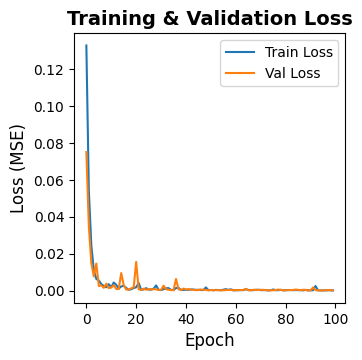

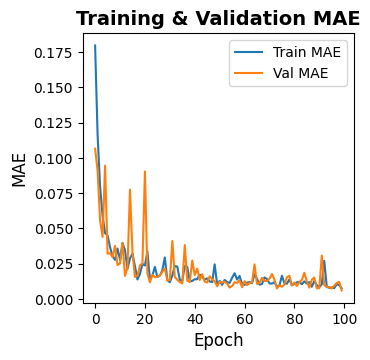

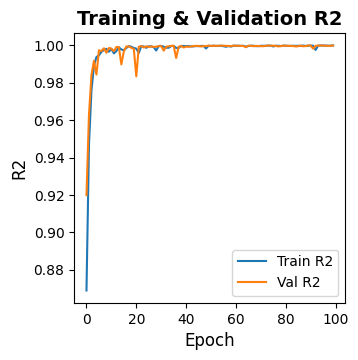

In [21]:
# @title Step NN1: Neural Network training

nn_model = build_nn_model()
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32,
             validation_split=0.2, verbose=1)

# Evaluate on test set
loss, mae, r2 = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Neural Network: Loss = {loss:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")



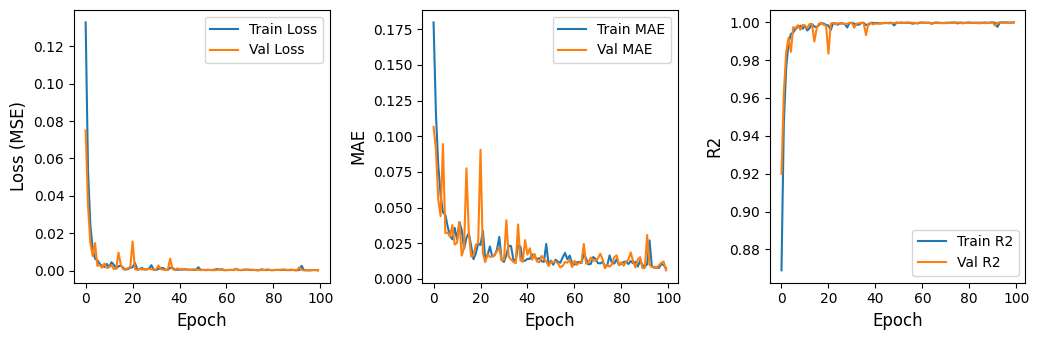

In [27]:
# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(10.5, 3.5))

# Plot 1: Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch', fontdict=font_properties)
axes[0].set_ylabel('Loss (MSE)', fontdict=font_properties)
# axes[0].set_title('Training & Validation Loss', fontdict={'family': 'sans-serif', 'size': 14, 'weight': 'bold'})
axes[0].legend()

# Plot 2: MAE
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch', fontdict=font_properties)
axes[1].set_ylabel('MAE', fontdict=font_properties)
# axes[1].set_title('Training & Validation MAE', fontdict={'family': 'sans-serif', 'size': 14, 'weight': 'bold'})
axes[1].legend()

# Plot 3: R2 Score
axes[2].plot(history.history['r2_score'], label='Train R2')
axes[2].plot(history.history['val_r2_score'], label='Val R2')
axes[2].set_xlabel('Epoch', fontdict=font_properties)
axes[2].set_ylabel('R2', fontdict=font_properties)
# axes[2].set_title('Training & Validation R2', fontdict={'family': 'sans-serif', 'size': 14, 'weight': 'bold'})
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.savefig("NN_train_val_vs_epoch.png", dpi=600, bbox_inches='tight')
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Comparison of best ML prediction of alpha:    Predicted α (cm^-1)  Actual α (cm^-1)
0         46022.429688      46356.294755
1          1606.286621       1294.223234
2         15031.200195      15324.037696
3           248.538559        226.480560
4           173.419418          0.010434
5           350.726074        352.145215
6         79258.773438      79414.667645
7           101.464348         71.456331
8         66326.671875      66416.392892
9           325.651855        169.912138


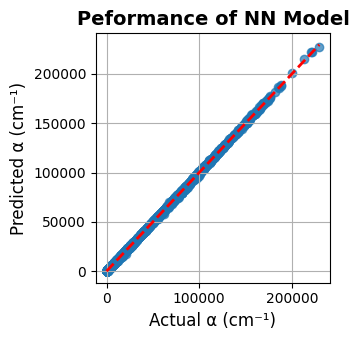

In [39]:
# @title Step NN2: Predict Alpha for Test Set
# Use the same preprocessor and trained model as before
best_model = nn_model

# Predict using scaled test set
alpha_test_scaled_pred = best_model.predict(X_test)

# Inverse transform to get predictions in original scale
alpha_test_pred = preprocessor.output_scaler.inverse_transform(alpha_test_scaled_pred.reshape(-1, 1))
alpha_test_true = preprocessor.output_scaler.inverse_transform(y_test.values)

# Display a few prediction vs actual values

comparison_df = pd.DataFrame({
    "Predicted α (cm^-1)": alpha_test_pred.flatten(),
    "Actual α (cm^-1)": alpha_test_true.flatten()
})

print(f"Comparison of best ML prediction of alpha: {comparison_df.head(10)}")

# plot the final predicted vs actual results

plt.figure(figsize=(3.5, 3.5))

# Set font type and sizes
font_properties = {'family': 'sans-serif', 'size': 12}  # or 'sans-serif', 'monospace', etc.

plt.scatter(alpha_test_true, alpha_test_pred, alpha=0.7)

# Increase line width of the red dashed diagonal
plt.plot(
    [min(alpha_test_true), max(alpha_test_true)],
    [min(alpha_test_true), max(alpha_test_true)],
    'r--', linewidth=2.0  # Line width here
)

plt.xlabel("Actual α (cm⁻¹)", fontdict=font_properties)
plt.ylabel("Predicted α (cm⁻¹)", fontdict=font_properties)
plt.title("Peformance of NN Model", fontdict={'family': 'sans-serif', 'size': 14, 'weight': 'bold'})

plt.grid(True)
plt.tight_layout()

# Save figure in high resolution
plt.savefig("NN_predicted_vs_actual_alpha.png", dpi=600, bbox_inches='tight')
plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


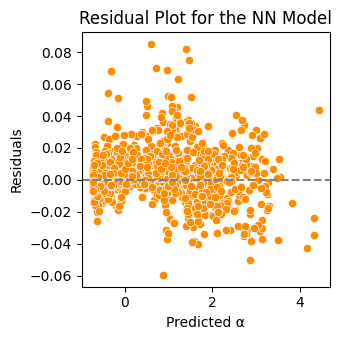

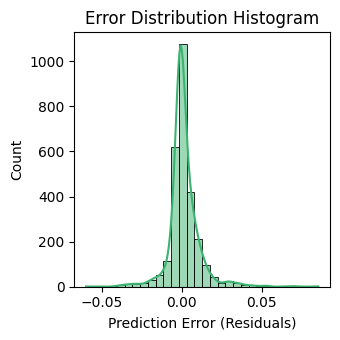

In [55]:
# @title Step NN3: Residual Analysis
# Calculate residuals
best_model = nn_model
y_pred = best_model.predict(X_test).flatten()
residuals = y_test.values.ravel() - y_pred

plt.figure(figsize=(3.5,3.5))
sns.scatterplot(x=y_pred, y=residuals, color='darkorange')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted α')
plt.ylabel('Residuals')
plt.title('Residual Plot for the NN Model')
plt.tight_layout()
plt.show()

#
plt.figure(figsize=(3.5,3.5))
sns.histplot(residuals, bins=30, kde=True, color='mediumseagreen')
plt.xlabel('Prediction Error (Residuals)')
plt.title('Error Distribution Histogram')
plt.tight_layout()
plt.show()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
50/50 ━━━

ExactExplainer explainer:   1%|          | 29/2800 [00:00<?, ?it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   1%|          | 31/2800 [00:10<06:45,  6.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   1%|          | 32/2800 [00:10<10:06,  4.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   1%|          | 33/2800 [00:11<12:34,  3.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   1%|          | 34/2800 [00:11<13:25,  3.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   1%|▏         | 35/2800 [00:11<13:38,  3.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   1%|▏         | 36/2800 [00:12<14:10,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   1%|▏         | 37/2800 [00:12<14:19,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   1%|▏         | 38/2800 [00:12<14:22,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   1%|▏         | 39/2800 [00:13<13:50,  3.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   1%|▏         | 40/2800 [00:13<14:08,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   1%|▏         | 41/2800 [00:13<13:13,  3.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 42/2800 [00:13<13:38,  3.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 43/2800 [00:14<14:10,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 44/2800 [00:14<14:10,  3.24it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 45/2800 [00:14<13:42,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 46/2800 [00:15<13:51,  3.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   2%|▏         | 47/2800 [00:15<14:59,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 48/2800 [00:15<15:46,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   2%|▏         | 49/2800 [00:16<17:16,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 50/2800 [00:16<18:18,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:   2%|▏         | 51/2800 [00:17<20:59,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 52/2800 [00:17<19:32,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 53/2800 [00:18<18:00,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 54/2800 [00:18<18:07,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 55/2800 [00:18<16:38,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 56/2800 [00:19<16:05,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 57/2800 [00:19<15:41,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 58/2800 [00:19<14:53,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 59/2800 [00:20<14:43,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 60/2800 [00:20<14:48,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 61/2800 [00:20<14:53,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 62/2800 [00:21<14:42,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 63/2800 [00:21<14:42,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 64/2800 [00:21<14:07,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 65/2800 [00:21<14:05,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 66/2800 [00:22<14:15,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 67/2800 [00:22<14:27,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 68/2800 [00:22<14:01,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 69/2800 [00:23<14:10,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▎         | 70/2800 [00:23<14:21,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 71/2800 [00:23<13:57,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 72/2800 [00:24<14:20,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 73/2800 [00:24<13:46,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 74/2800 [00:24<13:48,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 75/2800 [00:25<13:53,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 76/2800 [00:25<14:01,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 77/2800 [00:25<13:24,  3.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 78/2800 [00:25<13:25,  3.38it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 79/2800 [00:26<13:05,  3.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 80/2800 [00:26<12:41,  3.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 81/2800 [00:26<13:24,  3.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 82/2800 [00:27<13:03,  3.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 83/2800 [00:27<12:41,  3.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 84/2800 [00:27<12:49,  3.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   3%|▎         | 85/2800 [00:28<15:21,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 86/2800 [00:28<16:53,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 87/2800 [00:28<17:03,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 88/2800 [00:29<17:00,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   3%|▎         | 89/2800 [00:29<20:16,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 90/2800 [00:30<18:17,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 91/2800 [00:30<17:07,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 92/2800 [00:30<15:50,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 93/2800 [00:31<15:33,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 94/2800 [00:31<14:34,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   3%|▎         | 95/2800 [00:31<13:48,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 96/2800 [00:31<13:20,  3.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   3%|▎         | 97/2800 [00:32<13:43,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▎         | 98/2800 [00:32<14:04,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▎         | 99/2800 [00:32<14:08,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▎         | 100/2800 [00:33<13:53,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▎         | 101/2800 [00:33<13:54,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▎         | 102/2800 [00:33<13:27,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▎         | 103/2800 [00:34<13:47,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▎         | 104/2800 [00:34<13:56,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 105/2800 [00:34<14:11,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 106/2800 [00:35<14:16,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 107/2800 [00:35<14:09,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 108/2800 [00:35<13:44,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 109/2800 [00:36<14:00,  3.20it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 110/2800 [00:36<14:05,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 111/2800 [00:36<13:33,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 112/2800 [00:36<13:10,  3.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 113/2800 [00:37<13:28,  3.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 114/2800 [00:37<13:22,  3.35it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 115/2800 [00:37<13:01,  3.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 116/2800 [00:38<12:48,  3.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 117/2800 [00:38<13:15,  3.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 118/2800 [00:38<13:35,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 119/2800 [00:38<13:37,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 120/2800 [00:39<14:21,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 121/2800 [00:39<14:15,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   4%|▍         | 122/2800 [00:40<15:45,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 123/2800 [00:40<19:14,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 124/2800 [00:41<18:25,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 125/2800 [00:41<21:10,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   4%|▍         | 126/2800 [00:42<21:53,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▍         | 127/2800 [00:42<19:35,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 128/2800 [00:42<17:56,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 129/2800 [00:43<16:03,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▍         | 130/2800 [00:43<15:03,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 131/2800 [00:43<15:03,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 132/2800 [00:44<14:18,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▍         | 133/2800 [00:44<13:34,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 134/2800 [00:44<13:48,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 135/2800 [00:44<14:01,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 136/2800 [00:45<14:04,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▍         | 137/2800 [00:45<14:06,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 138/2800 [00:45<14:15,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▍         | 139/2800 [00:46<14:16,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▌         | 140/2800 [00:46<13:33,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 141/2800 [00:46<13:44,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 142/2800 [00:47<13:13,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 143/2800 [00:47<13:22,  3.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 144/2800 [00:47<13:48,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 145/2800 [00:48<13:25,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▌         | 146/2800 [00:48<13:33,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 147/2800 [00:48<13:10,  3.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 148/2800 [00:48<12:51,  3.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▌         | 149/2800 [00:49<12:44,  3.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   5%|▌         | 150/2800 [00:49<13:22,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 151/2800 [00:49<13:35,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 152/2800 [00:50<13:42,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▌         | 153/2800 [00:50<13:58,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 154/2800 [00:50<14:10,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 155/2800 [00:51<13:57,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 156/2800 [00:51<13:32,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 157/2800 [00:51<13:43,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   6%|▌         | 158/2800 [00:52<14:45,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   6%|▌         | 159/2800 [00:52<18:34,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 160/2800 [00:53<17:44,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   6%|▌         | 161/2800 [00:53<18:22,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 162/2800 [00:54<20:16,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 163/2800 [00:54<18:31,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 164/2800 [00:54<17:15,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 165/2800 [00:55<15:55,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 166/2800 [00:55<15:22,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 167/2800 [00:55<14:56,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 168/2800 [00:56<14:33,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 169/2800 [00:56<13:51,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 170/2800 [00:56<13:19,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 171/2800 [00:56<13:34,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 172/2800 [00:57<13:22,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 173/2800 [00:57<13:11,  3.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 174/2800 [00:57<13:27,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▋         | 175/2800 [00:58<13:24,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▋         | 176/2800 [00:58<13:40,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▋         | 177/2800 [00:58<13:25,  3.26it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▋         | 178/2800 [00:59<13:41,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▋         | 179/2800 [00:59<13:53,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▋         | 180/2800 [00:59<13:59,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▋         | 181/2800 [01:00<13:45,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▋         | 182/2800 [01:00<14:00,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 183/2800 [01:00<13:30,  3.23it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 184/2800 [01:00<13:40,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 185/2800 [01:01<13:21,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 186/2800 [01:01<13:41,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 187/2800 [01:01<13:56,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 188/2800 [01:02<13:27,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 189/2800 [01:02<13:55,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 190/2800 [01:02<13:33,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 191/2800 [01:03<12:56,  3.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 192/2800 [01:03<12:51,  3.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 193/2800 [01:03<13:18,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 194/2800 [01:04<13:01,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   7%|▋         | 195/2800 [01:04<14:51,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 196/2800 [01:04<15:12,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 197/2800 [01:05<16:25,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   7%|▋         | 198/2800 [01:05<19:47,  2.19it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 199/2800 [01:06<21:49,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 200/2800 [01:06<19:06,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 201/2800 [01:07<16:58,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 202/2800 [01:07<16:01,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 203/2800 [01:07<15:33,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 204/2800 [01:08<15:08,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 205/2800 [01:08<14:39,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 206/2800 [01:08<14:27,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 207/2800 [01:08<13:47,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 208/2800 [01:09<13:42,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 209/2800 [01:09<14:03,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 210/2800 [01:09<14:07,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 211/2800 [01:10<13:58,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 212/2800 [01:10<13:50,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 213/2800 [01:10<13:27,  3.20it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 214/2800 [01:11<13:25,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 215/2800 [01:11<13:29,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 216/2800 [01:11<13:49,  3.12it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 217/2800 [01:12<13:14,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 218/2800 [01:12<13:18,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 219/2800 [01:12<13:40,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 220/2800 [01:13<12:58,  3.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 221/2800 [01:13<13:03,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 222/2800 [01:13<13:27,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 223/2800 [01:13<13:08,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 224/2800 [01:14<13:25,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 225/2800 [01:14<12:59,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 226/2800 [01:14<13:19,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 227/2800 [01:15<12:37,  3.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 228/2800 [01:15<12:41,  3.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 229/2800 [01:15<12:45,  3.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 230/2800 [01:16<13:17,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   8%|▊         | 231/2800 [01:16<14:56,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 232/2800 [01:17<16:25,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 233/2800 [01:17<19:18,  2.21it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 234/2800 [01:18<21:32,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 235/2800 [01:18<21:42,  1.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 236/2800 [01:19<18:41,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 237/2800 [01:19<17:07,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 238/2800 [01:19<16:00,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▊         | 239/2800 [01:19<14:36,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▊         | 240/2800 [01:20<14:06,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▊         | 241/2800 [01:20<14:00,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▊         | 242/2800 [01:20<13:09,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▊         | 243/2800 [01:21<12:44,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▊         | 244/2800 [01:21<12:58,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 245/2800 [01:21<12:26,  3.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 246/2800 [01:22<12:56,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 247/2800 [01:22<13:20,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 248/2800 [01:22<13:27,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 249/2800 [01:23<13:31,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 250/2800 [01:23<13:05,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 251/2800 [01:23<13:11,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 252/2800 [01:23<12:56,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 253/2800 [01:24<12:42,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 254/2800 [01:24<13:01,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 255/2800 [01:24<13:14,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 256/2800 [01:25<13:20,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 257/2800 [01:25<13:30,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 258/2800 [01:25<13:19,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 259/2800 [01:26<12:52,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 260/2800 [01:26<13:09,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 261/2800 [01:26<12:56,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 262/2800 [01:26<12:58,  3.26it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 263/2800 [01:27<13:08,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 264/2800 [01:27<12:49,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▉         | 265/2800 [01:27<12:37,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|▉         | 266/2800 [01:28<13:01,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|▉         | 267/2800 [01:28<12:57,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|▉         | 268/2800 [01:28<14:49,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|▉         | 269/2800 [01:29<16:00,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  10%|▉         | 270/2800 [01:30<19:11,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  10%|▉         | 271/2800 [01:30<21:13,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|▉         | 272/2800 [01:31<18:59,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|▉         | 273/2800 [01:31<17:18,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|▉         | 274/2800 [01:31<15:51,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|▉         | 275/2800 [01:31<15:04,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|▉         | 276/2800 [01:32<14:37,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|▉         | 277/2800 [01:32<14:34,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|▉         | 278/2800 [01:32<13:57,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|▉         | 279/2800 [01:33<13:19,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|█         | 280/2800 [01:33<12:54,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 281/2800 [01:33<12:53,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|█         | 282/2800 [01:34<13:03,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|█         | 283/2800 [01:34<13:17,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 284/2800 [01:34<13:25,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 285/2800 [01:35<12:57,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 286/2800 [01:35<13:04,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 287/2800 [01:35<12:35,  3.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|█         | 288/2800 [01:35<12:24,  3.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|█         | 289/2800 [01:36<12:15,  3.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 290/2800 [01:36<12:10,  3.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 291/2800 [01:36<12:34,  3.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 292/2800 [01:37<12:46,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|█         | 293/2800 [01:37<12:56,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  10%|█         | 294/2800 [01:37<12:42,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 295/2800 [01:38<12:37,  3.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 296/2800 [01:38<12:32,  3.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 297/2800 [01:38<12:50,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 298/2800 [01:38<12:35,  3.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 299/2800 [01:39<12:35,  3.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 300/2800 [01:39<12:30,  3.33it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 301/2800 [01:39<13:03,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 302/2800 [01:40<13:22,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 303/2800 [01:40<13:22,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  11%|█         | 304/2800 [01:40<14:14,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 305/2800 [01:41<14:35,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  11%|█         | 306/2800 [01:41<17:51,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  11%|█         | 307/2800 [01:42<18:22,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 308/2800 [01:42<17:56,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 309/2800 [01:43<18:53,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 310/2800 [01:43<16:32,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 311/2800 [01:43<15:26,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 312/2800 [01:44<14:49,  2.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 313/2800 [01:44<14:32,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 314/2800 [01:44<14:16,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█▏        | 315/2800 [01:45<13:45,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█▏        | 316/2800 [01:45<13:08,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█▏        | 317/2800 [01:45<13:06,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█▏        | 318/2800 [01:46<12:45,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█▏        | 319/2800 [01:46<12:31,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█▏        | 320/2800 [01:46<12:47,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█▏        | 321/2800 [01:46<12:42,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 322/2800 [01:47<12:40,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 323/2800 [01:47<12:46,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 324/2800 [01:47<13:02,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 325/2800 [01:48<13:19,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 326/2800 [01:48<12:55,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 327/2800 [01:48<12:32,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 328/2800 [01:49<12:44,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 329/2800 [01:49<12:57,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 330/2800 [01:49<12:43,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 331/2800 [01:50<12:58,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  12%|█▏        | 332/2800 [01:50<13:53,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 333/2800 [01:50<13:39,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 334/2800 [01:51<12:57,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 335/2800 [01:51<12:39,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 336/2800 [01:51<12:59,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 337/2800 [01:52<13:07,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 338/2800 [01:52<12:55,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 339/2800 [01:52<12:25,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 340/2800 [01:52<12:33,  3.26it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 341/2800 [01:53<13:04,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 342/2800 [01:53<16:03,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  12%|█▏        | 343/2800 [01:54<15:46,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  12%|█▏        | 344/2800 [01:54<18:47,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 345/2800 [01:55<19:44,  2.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 346/2800 [01:55<17:42,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 347/2800 [01:55<15:38,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 348/2800 [01:56<15:02,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  12%|█▏        | 349/2800 [01:56<15:08,  2.70it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▎        | 350/2800 [01:57<14:36,  2.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 351/2800 [01:57<14:17,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 352/2800 [01:57<14:06,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 353/2800 [01:58<13:40,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 354/2800 [01:58<13:05,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 355/2800 [01:58<12:58,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 356/2800 [01:58<12:39,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 357/2800 [01:59<12:24,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 358/2800 [01:59<12:37,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 359/2800 [01:59<12:21,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 360/2800 [02:00<12:43,  3.19it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 361/2800 [02:00<12:33,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 362/2800 [02:00<12:21,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 363/2800 [02:01<12:18,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 364/2800 [02:01<12:28,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 365/2800 [02:01<12:14,  3.32it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 366/2800 [02:01<12:38,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 367/2800 [02:02<12:49,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 368/2800 [02:02<12:25,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 369/2800 [02:02<12:46,  3.17it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 370/2800 [02:03<12:16,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 371/2800 [02:03<12:27,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 372/2800 [02:03<13:50,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 373/2800 [02:04<13:10,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 374/2800 [02:04<12:47,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 375/2800 [02:04<12:49,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 376/2800 [02:05<12:29,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 377/2800 [02:05<12:55,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▎        | 378/2800 [02:05<14:42,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  14%|█▎        | 379/2800 [02:06<17:52,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▎        | 380/2800 [02:07<17:55,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  14%|█▎        | 381/2800 [02:07<19:33,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▎        | 382/2800 [02:07<17:32,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▎        | 383/2800 [02:08<16:33,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▎        | 384/2800 [02:08<15:35,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 385/2800 [02:08<14:25,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 386/2800 [02:09<13:39,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 387/2800 [02:09<13:39,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 388/2800 [02:09<13:23,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 389/2800 [02:10<12:34,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 390/2800 [02:10<12:45,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 391/2800 [02:10<12:51,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 392/2800 [02:11<12:20,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  14%|█▍        | 393/2800 [02:11<12:13,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 394/2800 [02:11<11:49,  3.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 395/2800 [02:11<11:57,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 396/2800 [02:12<11:57,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 397/2800 [02:12<12:20,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 398/2800 [02:12<12:11,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 399/2800 [02:13<12:25,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 400/2800 [02:13<13:08,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 401/2800 [02:13<12:33,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 402/2800 [02:14<12:19,  3.24it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 403/2800 [02:14<13:28,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 404/2800 [02:14<13:00,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 405/2800 [02:15<12:29,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▍        | 406/2800 [02:15<12:31,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▍        | 407/2800 [02:15<12:48,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 408/2800 [02:16<12:58,  3.07it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 409/2800 [02:16<12:39,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 410/2800 [02:16<12:42,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▍        | 411/2800 [02:17<12:25,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 412/2800 [02:17<12:07,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▍        | 413/2800 [02:17<11:30,  3.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 414/2800 [02:18<13:30,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 415/2800 [02:18<14:51,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 416/2800 [02:18<16:22,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  15%|█▍        | 417/2800 [02:19<16:16,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  15%|█▍        | 418/2800 [02:19<18:06,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 419/2800 [02:20<16:11,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▌        | 420/2800 [02:20<15:32,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▌        | 421/2800 [02:20<14:41,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 422/2800 [02:21<14:12,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 423/2800 [02:21<13:44,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  15%|█▌        | 424/2800 [02:21<13:29,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▌        | 425/2800 [02:22<13:06,  3.02it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▌        | 426/2800 [02:22<12:36,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▌        | 427/2800 [02:22<12:22,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 428/2800 [02:23<12:33,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▌        | 429/2800 [02:23<12:38,  3.13it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 430/2800 [02:23<12:06,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 431/2800 [02:24<12:26,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▌        | 432/2800 [02:24<12:06,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 433/2800 [02:24<11:50,  3.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 434/2800 [02:24<12:09,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 435/2800 [02:25<12:32,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 436/2800 [02:25<12:07,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 437/2800 [02:25<11:43,  3.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 438/2800 [02:26<11:49,  3.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 439/2800 [02:26<12:08,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 440/2800 [02:26<12:19,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 441/2800 [02:27<13:01,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 442/2800 [02:27<12:53,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 443/2800 [02:27<12:44,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 444/2800 [02:28<13:50,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 445/2800 [02:28<13:01,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 446/2800 [02:28<12:28,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 447/2800 [02:29<12:03,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 448/2800 [02:29<11:49,  3.31it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 449/2800 [02:29<11:55,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 450/2800 [02:30<12:14,  3.20it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 451/2800 [02:30<15:46,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 452/2800 [02:31<18:14,  2.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 453/2800 [02:31<20:07,  1.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▌        | 454/2800 [02:32<18:39,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▋        | 455/2800 [02:32<16:30,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▋        | 456/2800 [02:32<15:18,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▋        | 457/2800 [02:33<14:26,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▋        | 458/2800 [02:33<14:02,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▋        | 459/2800 [02:33<12:58,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▋        | 460/2800 [02:34<12:44,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▋        | 461/2800 [02:34<12:42,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  16%|█▋        | 462/2800 [02:34<13:00,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 463/2800 [02:35<12:32,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 464/2800 [02:35<12:05,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 465/2800 [02:35<12:14,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 466/2800 [02:35<11:50,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 467/2800 [02:36<11:37,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 468/2800 [02:36<12:39,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 469/2800 [02:36<12:22,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 470/2800 [02:37<12:27,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 471/2800 [02:37<12:34,  3.09it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 472/2800 [02:37<12:16,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 473/2800 [02:38<12:07,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 474/2800 [02:38<12:20,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 475/2800 [02:38<12:19,  3.14it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 476/2800 [02:39<12:29,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 477/2800 [02:39<12:28,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 478/2800 [02:39<12:27,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 479/2800 [02:40<12:19,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 480/2800 [02:40<12:00,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 481/2800 [02:40<13:09,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 482/2800 [02:41<12:50,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 483/2800 [02:41<12:40,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  17%|█▋        | 484/2800 [02:41<12:10,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 485/2800 [02:42<12:13,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  17%|█▋        | 486/2800 [02:42<13:23,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  17%|█▋        | 487/2800 [02:42<14:28,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  17%|█▋        | 488/2800 [02:43<17:14,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  17%|█▋        | 489/2800 [02:44<17:27,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 490/2800 [02:44<18:19,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 491/2800 [02:44<16:30,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 492/2800 [02:45<15:11,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 493/2800 [02:45<14:01,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 494/2800 [02:45<13:37,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 495/2800 [02:46<12:56,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 496/2800 [02:46<12:37,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 497/2800 [02:46<11:55,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 498/2800 [02:46<11:43,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 499/2800 [02:47<11:38,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 500/2800 [02:47<11:25,  3.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 501/2800 [02:47<11:16,  3.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 502/2800 [02:48<11:16,  3.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 503/2800 [02:48<11:26,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 504/2800 [02:48<11:53,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 505/2800 [02:49<11:37,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 506/2800 [02:49<11:38,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 507/2800 [02:49<11:29,  3.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 508/2800 [02:49<11:36,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 509/2800 [02:50<11:44,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  18%|█▊        | 510/2800 [02:50<12:54,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 511/2800 [02:51<12:47,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 512/2800 [02:51<12:34,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 513/2800 [02:51<12:12,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 514/2800 [02:51<12:11,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 515/2800 [02:52<12:59,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 516/2800 [02:52<12:28,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 517/2800 [02:52<12:25,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 518/2800 [02:53<13:14,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▊        | 519/2800 [02:53<12:29,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▊        | 520/2800 [02:53<11:54,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▊        | 521/2800 [02:54<11:56,  3.18it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  19%|█▊        | 522/2800 [02:54<13:18,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  19%|█▊        | 523/2800 [02:55<13:52,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▊        | 524/2800 [02:55<14:13,  2.67it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 525/2800 [02:55<15:03,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 526/2800 [02:56<15:26,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  19%|█▉        | 527/2800 [02:56<17:49,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 528/2800 [02:57<16:12,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 529/2800 [02:57<16:00,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 530/2800 [02:58<14:31,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 531/2800 [02:58<13:16,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 532/2800 [02:58<12:24,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 533/2800 [02:58<12:16,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 534/2800 [02:59<12:25,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 535/2800 [02:59<11:58,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 536/2800 [02:59<13:11,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 537/2800 [03:00<13:00,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 538/2800 [03:00<12:23,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 539/2800 [03:00<12:12,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 540/2800 [03:01<12:00,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 541/2800 [03:01<11:36,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 542/2800 [03:01<11:44,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 543/2800 [03:02<11:27,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 544/2800 [03:02<11:38,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  19%|█▉        | 545/2800 [03:02<11:39,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|█▉        | 546/2800 [03:03<11:53,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|█▉        | 547/2800 [03:03<11:37,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|█▉        | 548/2800 [03:03<11:51,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  20%|█▉        | 549/2800 [03:04<12:33,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 550/2800 [03:04<11:58,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|█▉        | 551/2800 [03:04<11:28,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|█▉        | 552/2800 [03:04<11:39,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|█▉        | 553/2800 [03:05<11:52,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 554/2800 [03:05<11:57,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 555/2800 [03:05<11:51,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 556/2800 [03:06<11:48,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 557/2800 [03:06<11:48,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|█▉        | 558/2800 [03:06<11:33,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  20%|█▉        | 559/2800 [03:07<12:34,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  20%|██        | 560/2800 [03:07<15:44,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  20%|██        | 561/2800 [03:08<15:32,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  20%|██        | 562/2800 [03:08<15:38,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 563/2800 [03:09<16:06,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 564/2800 [03:09<15:46,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 565/2800 [03:09<14:25,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 566/2800 [03:10<13:31,  2.75it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 567/2800 [03:10<13:03,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 568/2800 [03:10<12:24,  3.00it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|██        | 569/2800 [03:11<12:17,  3.02it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  20%|██        | 570/2800 [03:11<12:09,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 571/2800 [03:11<12:13,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 572/2800 [03:12<12:12,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 573/2800 [03:12<11:41,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  20%|██        | 574/2800 [03:12<11:49,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 575/2800 [03:12<11:46,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 576/2800 [03:13<11:52,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 577/2800 [03:13<11:56,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 578/2800 [03:13<11:33,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 579/2800 [03:14<11:03,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 580/2800 [03:14<11:24,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 581/2800 [03:14<11:10,  3.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 582/2800 [03:15<11:15,  3.28it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 583/2800 [03:15<11:29,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 584/2800 [03:15<11:29,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 585/2800 [03:16<11:18,  3.26it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 586/2800 [03:16<10:59,  3.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 587/2800 [03:16<11:22,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 588/2800 [03:16<11:34,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 589/2800 [03:17<11:39,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 590/2800 [03:17<12:40,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 591/2800 [03:18<12:04,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 592/2800 [03:18<11:32,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 593/2800 [03:18<11:13,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 594/2800 [03:18<11:27,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██▏       | 595/2800 [03:19<11:33,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██▏       | 596/2800 [03:19<12:57,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  21%|██▏       | 597/2800 [03:20<16:02,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  21%|██▏       | 598/2800 [03:20<18:18,  2.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██▏       | 599/2800 [03:21<17:33,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██▏       | 600/2800 [03:21<16:52,  2.17it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██▏       | 601/2800 [03:22<15:08,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 602/2800 [03:22<14:13,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 603/2800 [03:22<13:33,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 604/2800 [03:23<12:57,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 605/2800 [03:23<12:30,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 606/2800 [03:23<12:28,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 607/2800 [03:24<12:32,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 608/2800 [03:24<12:05,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 609/2800 [03:24<11:39,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 610/2800 [03:24<11:34,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 611/2800 [03:25<11:44,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 612/2800 [03:25<11:35,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 613/2800 [03:25<11:25,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 614/2800 [03:26<11:35,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 615/2800 [03:26<11:14,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 616/2800 [03:26<10:54,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 617/2800 [03:27<11:40,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 618/2800 [03:27<11:43,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 619/2800 [03:27<11:29,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 620/2800 [03:28<11:32,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 621/2800 [03:28<11:43,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 622/2800 [03:28<11:24,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 623/2800 [03:29<11:12,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 624/2800 [03:29<11:13,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 625/2800 [03:29<10:59,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 626/2800 [03:29<10:56,  3.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  22%|██▏       | 627/2800 [03:30<11:17,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 628/2800 [03:30<11:22,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 629/2800 [03:30<11:00,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▎       | 630/2800 [03:31<11:21,  3.19it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 631/2800 [03:31<11:42,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  23%|██▎       | 632/2800 [03:31<12:00,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 633/2800 [03:32<13:15,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  23%|██▎       | 634/2800 [03:32<15:49,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  23%|██▎       | 635/2800 [03:33<17:49,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 636/2800 [03:34<18:09,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  23%|██▎       | 637/2800 [03:34<16:25,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 638/2800 [03:34<15:00,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 639/2800 [03:35<13:38,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 640/2800 [03:35<12:36,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 641/2800 [03:35<12:16,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 642/2800 [03:36<12:14,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 643/2800 [03:36<12:06,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 644/2800 [03:36<11:57,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 645/2800 [03:36<11:34,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 646/2800 [03:37<11:33,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 647/2800 [03:37<12:00,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 648/2800 [03:38<11:59,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 649/2800 [03:38<12:00,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  23%|██▎       | 650/2800 [03:38<11:45,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 651/2800 [03:38<11:42,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 652/2800 [03:39<12:28,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 653/2800 [03:39<12:54,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 654/2800 [03:40<12:36,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 655/2800 [03:40<11:57,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 656/2800 [03:40<11:28,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 657/2800 [03:41<11:39,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▎       | 658/2800 [03:41<11:27,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▎       | 659/2800 [03:41<11:19,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▎       | 660/2800 [03:41<11:26,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▎       | 661/2800 [03:42<12:04,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▎       | 662/2800 [03:42<11:55,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▎       | 663/2800 [03:42<11:39,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▎       | 664/2800 [03:43<11:12,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 665/2800 [03:43<11:12,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 666/2800 [03:43<11:49,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 667/2800 [03:44<14:55,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  24%|██▍       | 668/2800 [03:45<15:26,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 669/2800 [03:45<17:25,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  24%|██▍       | 670/2800 [03:46<18:50,  1.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 671/2800 [03:46<16:11,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 672/2800 [03:46<14:49,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 673/2800 [03:47<13:48,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 674/2800 [03:47<13:13,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 675/2800 [03:47<12:40,  2.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 676/2800 [03:48<12:00,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 677/2800 [03:48<11:17,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 678/2800 [03:48<11:21,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 679/2800 [03:49<11:01,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 680/2800 [03:49<11:14,  3.14it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 681/2800 [03:49<11:21,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 682/2800 [03:50<11:23,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 683/2800 [03:50<11:19,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 684/2800 [03:50<11:27,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 685/2800 [03:51<11:22,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 686/2800 [03:51<11:28,  3.07it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 687/2800 [03:51<11:06,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 688/2800 [03:51<11:01,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▍       | 689/2800 [03:52<10:58,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 690/2800 [03:52<11:20,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 691/2800 [03:52<11:24,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 692/2800 [03:53<11:27,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 693/2800 [03:53<11:25,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 694/2800 [03:53<11:01,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 695/2800 [03:54<10:47,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 696/2800 [03:54<11:12,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 697/2800 [03:54<11:01,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 698/2800 [03:55<10:53,  3.22it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▍       | 699/2800 [03:55<11:14,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 700/2800 [03:55<10:53,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 701/2800 [03:56<11:00,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  25%|██▌       | 702/2800 [03:56<12:25,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  25%|██▌       | 703/2800 [03:56<13:12,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  25%|██▌       | 704/2800 [03:57<14:16,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  25%|██▌       | 705/2800 [03:57<14:22,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  25%|██▌       | 706/2800 [03:58<16:31,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 707/2800 [03:58<16:43,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 708/2800 [03:59<16:05,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 709/2800 [03:59<15:39,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 710/2800 [04:00<15:16,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 711/2800 [04:00<13:51,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 712/2800 [04:00<13:12,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 713/2800 [04:01<12:33,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 714/2800 [04:01<11:58,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 715/2800 [04:01<11:35,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 716/2800 [04:02<12:34,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 717/2800 [04:02<12:12,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 718/2800 [04:02<11:34,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 719/2800 [04:03<12:33,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 720/2800 [04:03<12:16,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 721/2800 [04:04<12:48,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 722/2800 [04:04<12:22,  2.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 723/2800 [04:04<11:59,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 724/2800 [04:05<12:34,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 725/2800 [04:05<12:04,  2.86it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 726/2800 [04:05<11:55,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  26%|██▌       | 727/2800 [04:06<12:41,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 728/2800 [04:06<12:10,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 729/2800 [04:06<11:33,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 730/2800 [04:07<12:15,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 731/2800 [04:07<11:57,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 732/2800 [04:07<11:51,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  26%|██▌       | 733/2800 [04:08<12:38,  2.73it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 734/2800 [04:08<11:58,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  26%|██▋       | 735/2800 [04:08<12:47,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▋       | 736/2800 [04:09<15:23,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  26%|██▋       | 737/2800 [04:10<15:02,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  26%|██▋       | 738/2800 [04:10<16:19,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▋       | 739/2800 [04:11<17:03,  2.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▋       | 740/2800 [04:11<15:04,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▋       | 741/2800 [04:11<13:50,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▋       | 742/2800 [04:12<12:30,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 743/2800 [04:12<11:40,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 744/2800 [04:12<12:16,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 745/2800 [04:13<12:00,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 746/2800 [04:13<11:44,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 747/2800 [04:13<11:38,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 748/2800 [04:14<11:31,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 749/2800 [04:14<11:00,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 750/2800 [04:14<11:08,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 751/2800 [04:14<11:14,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 752/2800 [04:15<10:51,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 753/2800 [04:15<10:58,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 754/2800 [04:15<10:58,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 755/2800 [04:16<10:33,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  27%|██▋       | 756/2800 [04:16<11:41,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 757/2800 [04:16<11:31,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 758/2800 [04:17<12:16,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 759/2800 [04:17<11:38,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 760/2800 [04:17<10:59,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 761/2800 [04:18<10:55,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 762/2800 [04:18<11:06,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 763/2800 [04:18<11:11,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 764/2800 [04:19<11:07,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 765/2800 [04:19<11:06,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 766/2800 [04:19<10:54,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 767/2800 [04:20<10:49,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 768/2800 [04:20<10:44,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 769/2800 [04:20<10:50,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  28%|██▊       | 770/2800 [04:21<12:16,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  28%|██▊       | 771/2800 [04:21<14:30,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 772/2800 [04:22<16:24,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 773/2800 [04:23<17:34,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 774/2800 [04:23<16:08,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 775/2800 [04:23<14:13,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 776/2800 [04:24<13:19,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 777/2800 [04:24<12:38,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 778/2800 [04:24<12:01,  2.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 779/2800 [04:25<11:30,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 780/2800 [04:25<11:27,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 781/2800 [04:25<11:02,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 782/2800 [04:26<11:11,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 783/2800 [04:26<11:04,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 784/2800 [04:26<10:55,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 785/2800 [04:26<10:27,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 786/2800 [04:27<10:44,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 787/2800 [04:27<10:28,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 788/2800 [04:27<10:25,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 789/2800 [04:28<10:24,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 790/2800 [04:28<10:14,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 791/2800 [04:28<10:19,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 792/2800 [04:29<10:42,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 793/2800 [04:29<10:33,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 794/2800 [04:29<10:21,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 795/2800 [04:30<10:05,  3.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 796/2800 [04:30<10:08,  3.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 797/2800 [04:30<09:55,  3.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 798/2800 [04:30<10:18,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▊       | 799/2800 [04:31<11:21,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▊       | 800/2800 [04:31<11:15,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▊       | 801/2800 [04:32<10:42,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▊       | 802/2800 [04:32<10:31,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▊       | 803/2800 [04:32<10:09,  3.27it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▊       | 804/2800 [04:32<09:56,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 805/2800 [04:33<10:13,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  29%|██▉       | 806/2800 [04:33<13:24,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 807/2800 [04:34<14:02,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 808/2800 [04:34<16:06,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  29%|██▉       | 809/2800 [04:35<17:15,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 810/2800 [04:35<15:15,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 811/2800 [04:36<13:56,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 812/2800 [04:36<13:50,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 813/2800 [04:36<12:36,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 814/2800 [04:37<11:43,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 815/2800 [04:37<11:03,  2.99it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 816/2800 [04:37<10:57,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 817/2800 [04:38<10:57,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 818/2800 [04:38<10:55,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 819/2800 [04:38<10:47,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 820/2800 [04:39<10:45,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 821/2800 [04:39<10:36,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 822/2800 [04:39<10:45,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 823/2800 [04:40<10:44,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 824/2800 [04:40<10:42,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 825/2800 [04:40<11:28,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|██▉       | 826/2800 [04:41<10:47,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|██▉       | 827/2800 [04:41<10:15,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 828/2800 [04:41<10:05,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 829/2800 [04:41<10:20,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 830/2800 [04:42<11:16,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|██▉       | 831/2800 [04:42<11:01,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|██▉       | 832/2800 [04:43<10:40,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 833/2800 [04:43<10:36,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 834/2800 [04:43<10:29,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 835/2800 [04:43<10:35,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 836/2800 [04:44<10:35,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 837/2800 [04:44<10:15,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 838/2800 [04:44<10:29,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|██▉       | 839/2800 [04:45<10:30,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 840/2800 [04:45<10:43,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 841/2800 [04:46<13:31,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 842/2800 [04:46<13:05,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 843/2800 [04:47<13:24,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 844/2800 [04:47<15:16,  2.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 845/2800 [04:48<15:28,  2.10it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 846/2800 [04:48<14:08,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 847/2800 [04:48<13:06,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 848/2800 [04:49<12:37,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 849/2800 [04:49<11:50,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 850/2800 [04:49<11:19,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 851/2800 [04:50<11:49,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 852/2800 [04:50<11:32,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 853/2800 [04:50<10:56,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 854/2800 [04:51<11:42,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 855/2800 [04:51<11:03,  2.93it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 856/2800 [04:51<10:55,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 857/2800 [04:52<10:36,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 858/2800 [04:52<10:49,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 859/2800 [04:52<10:36,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 860/2800 [04:53<10:19,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 861/2800 [04:53<10:20,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 862/2800 [04:53<10:21,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 863/2800 [04:54<09:56,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  31%|███       | 864/2800 [04:54<10:47,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 865/2800 [04:54<10:48,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 866/2800 [04:55<10:46,  2.99it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 867/2800 [04:55<10:29,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 868/2800 [04:55<10:08,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 869/2800 [04:55<10:06,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 870/2800 [04:56<10:00,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 871/2800 [04:56<10:19,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 872/2800 [04:56<10:24,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 873/2800 [04:57<10:34,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 874/2800 [04:57<10:27,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███▏      | 875/2800 [04:57<10:23,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  31%|███▏      | 876/2800 [04:58<13:05,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  31%|███▏      | 877/2800 [04:59<13:41,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  31%|███▏      | 878/2800 [04:59<14:01,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███▏      | 879/2800 [05:00<15:29,  2.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███▏      | 880/2800 [05:00<15:48,  2.02it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███▏      | 881/2800 [05:00<14:16,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 882/2800 [05:01<13:10,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 883/2800 [05:01<12:06,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 884/2800 [05:01<11:28,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 885/2800 [05:02<11:06,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 886/2800 [05:02<10:35,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 887/2800 [05:02<10:29,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 888/2800 [05:03<10:13,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 889/2800 [05:03<10:01,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 890/2800 [05:03<10:08,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 891/2800 [05:04<09:57,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 892/2800 [05:04<10:00,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 893/2800 [05:04<10:02,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 894/2800 [05:05<10:13,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 895/2800 [05:05<10:50,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 896/2800 [05:05<10:18,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 897/2800 [05:06<10:14,  3.10it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 898/2800 [05:06<10:13,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 899/2800 [05:06<09:53,  3.20it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 900/2800 [05:07<10:59,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 901/2800 [05:07<10:50,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 902/2800 [05:07<10:26,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  32%|███▏      | 903/2800 [05:08<11:05,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 904/2800 [05:08<10:52,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 905/2800 [05:08<10:41,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 906/2800 [05:09<11:30,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 907/2800 [05:09<11:00,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 908/2800 [05:09<10:47,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 909/2800 [05:10<10:45,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▎      | 910/2800 [05:10<10:59,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 911/2800 [05:11<12:37,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  33%|███▎      | 912/2800 [05:11<14:16,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 913/2800 [05:11<13:37,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  33%|███▎      | 914/2800 [05:12<15:08,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 915/2800 [05:13<15:31,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 916/2800 [05:13<13:55,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 917/2800 [05:13<12:27,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 918/2800 [05:14<11:48,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  33%|███▎      | 919/2800 [05:14<11:48,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 920/2800 [05:14<11:22,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 921/2800 [05:15<10:42,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 922/2800 [05:15<10:15,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 923/2800 [05:15<10:06,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 924/2800 [05:15<10:09,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 925/2800 [05:16<10:41,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 926/2800 [05:16<10:27,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 927/2800 [05:17<10:19,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 928/2800 [05:17<09:52,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 929/2800 [05:17<09:58,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 930/2800 [05:17<09:56,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 931/2800 [05:18<10:34,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 932/2800 [05:18<10:31,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 933/2800 [05:18<10:28,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 934/2800 [05:19<10:18,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 935/2800 [05:19<10:10,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 936/2800 [05:19<10:13,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 937/2800 [05:20<10:58,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▎      | 938/2800 [05:20<10:50,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▎      | 939/2800 [05:21<10:32,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▎      | 940/2800 [05:21<10:12,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  34%|███▎      | 941/2800 [05:21<10:05,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▎      | 942/2800 [05:21<10:17,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▎      | 943/2800 [05:22<10:15,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▎      | 944/2800 [05:22<10:09,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  34%|███▍      | 945/2800 [05:23<11:07,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  34%|███▍      | 946/2800 [05:23<13:25,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  34%|███▍      | 947/2800 [05:24<15:15,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  34%|███▍      | 948/2800 [05:24<16:14,  1.90it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 949/2800 [05:25<16:11,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▍      | 950/2800 [05:25<14:23,  2.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 951/2800 [05:26<12:59,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 952/2800 [05:26<11:40,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 953/2800 [05:26<11:10,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  34%|███▍      | 954/2800 [05:27<10:48,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 955/2800 [05:27<10:42,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 956/2800 [05:27<10:16,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 957/2800 [05:27<10:11,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 958/2800 [05:28<10:16,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 959/2800 [05:28<09:53,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 960/2800 [05:28<09:58,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 961/2800 [05:29<09:50,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 962/2800 [05:29<09:42,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 963/2800 [05:29<09:51,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 964/2800 [05:30<09:50,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 965/2800 [05:30<09:43,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 966/2800 [05:30<09:49,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 967/2800 [05:31<10:00,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 968/2800 [05:31<10:02,  3.04it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 969/2800 [05:31<10:00,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 970/2800 [05:32<10:39,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▍      | 971/2800 [05:32<10:19,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 972/2800 [05:32<10:45,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 973/2800 [05:33<10:41,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 974/2800 [05:33<10:24,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 975/2800 [05:33<10:12,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  35%|███▍      | 976/2800 [05:34<10:54,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 977/2800 [05:34<10:14,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 978/2800 [05:35<10:54,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  35%|███▍      | 979/2800 [05:35<11:46,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  35%|███▌      | 980/2800 [05:35<12:31,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  35%|███▌      | 981/2800 [05:36<14:01,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 982/2800 [05:36<12:52,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  35%|███▌      | 983/2800 [05:37<13:28,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  35%|███▌      | 984/2800 [05:37<13:39,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 985/2800 [05:38<12:37,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 986/2800 [05:38<11:58,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▌      | 987/2800 [05:38<11:08,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 988/2800 [05:39<10:33,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 989/2800 [05:39<09:57,  3.03it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 990/2800 [05:39<10:00,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 991/2800 [05:40<10:04,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 992/2800 [05:40<09:43,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▌      | 993/2800 [05:40<09:43,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 994/2800 [05:41<09:42,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 995/2800 [05:41<09:45,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 996/2800 [05:41<09:58,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 997/2800 [05:42<09:41,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 998/2800 [05:42<09:26,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 999/2800 [05:42<09:32,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1000/2800 [05:42<09:20,  3.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1001/2800 [05:43<09:23,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1002/2800 [05:43<10:19,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1003/2800 [05:44<10:19,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1004/2800 [05:44<09:58,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1005/2800 [05:44<09:39,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1006/2800 [05:44<09:34,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1007/2800 [05:45<09:33,  3.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1008/2800 [05:45<09:43,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1009/2800 [05:45<09:46,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1010/2800 [05:46<09:28,  3.15it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1011/2800 [05:46<10:02,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 1012/2800 [05:46<10:02,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1013/2800 [05:47<09:34,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 1014/2800 [05:47<10:14,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  36%|███▋      | 1015/2800 [05:48<10:40,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  36%|███▋      | 1016/2800 [05:48<11:55,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  36%|███▋      | 1017/2800 [05:49<13:19,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  36%|███▋      | 1018/2800 [05:49<14:50,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▋      | 1019/2800 [05:50<16:03,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▋      | 1020/2800 [05:50<14:13,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▋      | 1021/2800 [05:51<12:53,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▋      | 1022/2800 [05:51<13:21,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 1023/2800 [05:51<11:54,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1024/2800 [05:52<11:10,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1025/2800 [05:52<10:40,  2.77it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1026/2800 [05:52<10:26,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1027/2800 [05:53<10:10,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1028/2800 [05:53<09:54,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 1029/2800 [05:53<09:49,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1030/2800 [05:54<09:27,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1031/2800 [05:54<10:10,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1032/2800 [05:54<10:05,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1033/2800 [05:55<09:52,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1034/2800 [05:55<09:44,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1035/2800 [05:55<09:30,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1036/2800 [05:56<09:16,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1037/2800 [05:56<09:21,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1038/2800 [05:56<09:24,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1039/2800 [05:56<09:10,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1040/2800 [05:57<09:03,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1041/2800 [05:57<09:08,  3.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1042/2800 [05:57<09:16,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1043/2800 [05:58<08:57,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1044/2800 [05:58<09:00,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1045/2800 [05:58<09:21,  3.13it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1046/2800 [05:59<09:23,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1047/2800 [05:59<09:29,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1048/2800 [05:59<09:34,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 1049/2800 [06:00<09:24,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1050/2800 [06:00<10:00,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1051/2800 [06:01<12:34,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  38%|███▊      | 1052/2800 [06:01<13:17,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1053/2800 [06:02<14:49,  1.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1054/2800 [06:02<14:54,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1055/2800 [06:03<12:56,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1056/2800 [06:03<12:32,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1057/2800 [06:03<11:49,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1058/2800 [06:04<11:10,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1059/2800 [06:04<10:39,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1060/2800 [06:04<10:17,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1061/2800 [06:05<10:03,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1062/2800 [06:05<10:01,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1063/2800 [06:05<09:55,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1064/2800 [06:06<09:37,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1065/2800 [06:06<09:25,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1066/2800 [06:06<09:05,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1067/2800 [06:07<08:58,  3.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1068/2800 [06:07<09:11,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1069/2800 [06:07<09:06,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1070/2800 [06:08<09:41,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1071/2800 [06:08<09:33,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1072/2800 [06:08<09:31,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1073/2800 [06:09<10:05,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1074/2800 [06:09<09:51,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1075/2800 [06:09<09:49,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  38%|███▊      | 1076/2800 [06:10<10:25,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1077/2800 [06:10<09:59,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  38%|███▊      | 1078/2800 [06:10<09:31,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▊      | 1079/2800 [06:11<09:21,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▊      | 1080/2800 [06:11<09:29,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▊      | 1081/2800 [06:11<09:30,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▊      | 1082/2800 [06:12<10:09,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▊      | 1083/2800 [06:12<09:54,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  39%|███▊      | 1084/2800 [06:12<10:37,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  39%|███▉      | 1085/2800 [06:13<12:44,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  39%|███▉      | 1086/2800 [06:14<14:02,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  39%|███▉      | 1087/2800 [06:14<14:54,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1088/2800 [06:15<13:40,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1089/2800 [06:15<12:26,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1090/2800 [06:15<11:23,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1091/2800 [06:16<10:30,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  39%|███▉      | 1092/2800 [06:16<10:48,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1093/2800 [06:16<10:23,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1094/2800 [06:17<10:02,  2.83it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1095/2800 [06:17<09:59,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 1096/2800 [06:17<09:47,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1097/2800 [06:18<09:21,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1098/2800 [06:18<09:19,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1099/2800 [06:18<09:28,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1100/2800 [06:19<09:09,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1101/2800 [06:19<09:00,  3.14it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1102/2800 [06:19<08:56,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1103/2800 [06:20<08:57,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1104/2800 [06:20<09:51,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  39%|███▉      | 1105/2800 [06:20<10:28,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1106/2800 [06:21<10:06,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1107/2800 [06:21<09:58,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1108/2800 [06:21<09:31,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1109/2800 [06:22<09:19,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1110/2800 [06:22<09:53,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1111/2800 [06:22<09:43,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1112/2800 [06:23<09:38,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1113/2800 [06:23<09:17,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1114/2800 [06:23<09:21,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1115/2800 [06:24<09:10,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1116/2800 [06:24<09:57,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1117/2800 [06:24<09:48,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  40%|███▉      | 1118/2800 [06:25<10:44,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|███▉      | 1119/2800 [06:25<11:12,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  40%|████      | 1120/2800 [06:26<11:52,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  40%|████      | 1121/2800 [06:26<12:05,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  40%|████      | 1122/2800 [06:27<13:44,  2.04it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  40%|████      | 1123/2800 [06:27<13:50,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1124/2800 [06:28<12:25,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1125/2800 [06:28<11:15,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1126/2800 [06:28<10:21,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1127/2800 [06:29<10:01,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1128/2800 [06:29<09:41,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1129/2800 [06:29<09:34,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1130/2800 [06:30<09:29,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1131/2800 [06:30<09:21,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1132/2800 [06:30<09:15,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 1133/2800 [06:31<09:04,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  40%|████      | 1134/2800 [06:31<09:10,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1135/2800 [06:31<08:58,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1136/2800 [06:32<09:02,  3.07it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1137/2800 [06:32<08:54,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1138/2800 [06:32<08:49,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1139/2800 [06:33<08:52,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  41%|████      | 1140/2800 [06:33<09:09,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1141/2800 [06:33<09:01,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1142/2800 [06:34<09:05,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1143/2800 [06:34<09:03,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1144/2800 [06:34<08:59,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1145/2800 [06:35<08:56,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1146/2800 [06:35<09:04,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1147/2800 [06:35<09:09,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1148/2800 [06:36<09:08,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1149/2800 [06:36<08:53,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1150/2800 [06:36<08:50,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1151/2800 [06:37<08:53,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1152/2800 [06:37<09:43,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 1153/2800 [06:37<09:34,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  41%|████      | 1154/2800 [06:38<10:24,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  41%|████▏     | 1155/2800 [06:38<12:27,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████▏     | 1156/2800 [06:39<12:23,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  41%|████▏     | 1157/2800 [06:39<13:43,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████▏     | 1158/2800 [06:40<14:06,  1.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████▏     | 1159/2800 [06:40<13:18,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████▏     | 1160/2800 [06:41<12:03,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████▏     | 1161/2800 [06:41<11:09,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1162/2800 [06:41<10:30,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1163/2800 [06:42<09:51,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1164/2800 [06:42<09:32,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1165/2800 [06:42<09:17,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1166/2800 [06:43<09:48,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1167/2800 [06:43<09:33,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1168/2800 [06:43<09:20,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 1169/2800 [06:44<09:02,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1170/2800 [06:44<09:07,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1171/2800 [06:44<09:48,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1172/2800 [06:45<09:34,  2.84it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1173/2800 [06:45<09:06,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1174/2800 [06:45<09:05,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1175/2800 [06:46<09:36,  2.82it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1176/2800 [06:46<09:56,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1177/2800 [06:47<09:38,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1178/2800 [06:47<09:28,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1179/2800 [06:47<09:05,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 1180/2800 [06:48<08:57,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1181/2800 [06:48<08:46,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1182/2800 [06:48<08:44,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1183/2800 [06:48<08:45,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1184/2800 [06:49<09:30,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 1185/2800 [06:49<09:22,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 1186/2800 [06:50<08:56,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  42%|████▏     | 1187/2800 [06:50<09:27,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  42%|████▏     | 1188/2800 [06:51<11:14,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  42%|████▏     | 1189/2800 [06:51<12:23,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▎     | 1190/2800 [06:52<13:35,  1.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  43%|████▎     | 1191/2800 [06:52<14:28,  1.85it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1192/2800 [06:53<12:44,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1193/2800 [06:53<11:32,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1194/2800 [06:53<10:59,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1195/2800 [06:54<10:17,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1196/2800 [06:54<09:53,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1197/2800 [06:54<09:33,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1198/2800 [06:55<09:17,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1199/2800 [06:55<09:44,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1200/2800 [06:55<09:37,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1201/2800 [06:56<09:05,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1202/2800 [06:56<08:57,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1203/2800 [06:56<08:46,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1204/2800 [06:57<08:41,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1205/2800 [06:57<08:36,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1206/2800 [06:57<09:24,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1207/2800 [06:58<09:14,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1208/2800 [06:58<09:02,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1209/2800 [06:58<08:53,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1210/2800 [06:59<08:45,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1211/2800 [06:59<08:23,  3.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  43%|████▎     | 1212/2800 [06:59<08:43,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1213/2800 [07:00<08:42,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1214/2800 [07:00<08:33,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1215/2800 [07:00<08:32,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1216/2800 [07:01<08:35,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 1217/2800 [07:01<08:32,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▎     | 1218/2800 [07:01<09:08,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▎     | 1219/2800 [07:02<09:05,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▎     | 1220/2800 [07:02<08:46,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▎     | 1221/2800 [07:02<08:46,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  44%|████▎     | 1222/2800 [07:03<10:36,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  44%|████▎     | 1223/2800 [07:03<12:15,  2.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▎     | 1224/2800 [07:04<13:32,  1.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  44%|████▍     | 1225/2800 [07:05<14:05,  1.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1226/2800 [07:05<12:36,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1227/2800 [07:05<11:20,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1228/2800 [07:06<10:30,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1229/2800 [07:06<09:57,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1230/2800 [07:06<09:28,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1231/2800 [07:07<09:15,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1232/2800 [07:07<09:04,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1233/2800 [07:07<08:42,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1234/2800 [07:08<09:13,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1235/2800 [07:08<08:53,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1236/2800 [07:08<08:48,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1237/2800 [07:09<08:37,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1238/2800 [07:09<08:36,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1239/2800 [07:09<08:34,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1240/2800 [07:10<08:30,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  44%|████▍     | 1241/2800 [07:10<08:51,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1242/2800 [07:10<08:33,  3.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1243/2800 [07:11<09:11,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1244/2800 [07:11<09:06,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1245/2800 [07:11<08:55,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 1246/2800 [07:12<08:39,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1247/2800 [07:12<08:23,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1248/2800 [07:12<08:23,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1249/2800 [07:13<08:17,  3.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1250/2800 [07:13<08:23,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1251/2800 [07:13<08:25,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1252/2800 [07:14<08:22,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1253/2800 [07:14<08:22,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1254/2800 [07:14<09:08,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1255/2800 [07:15<08:47,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1256/2800 [07:15<10:46,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1257/2800 [07:16<11:42,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 1258/2800 [07:16<11:44,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  45%|████▍     | 1259/2800 [07:17<11:27,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1260/2800 [07:17<11:44,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1261/2800 [07:18<12:14,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1262/2800 [07:18<11:10,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1263/2800 [07:18<10:11,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1264/2800 [07:19<09:42,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1265/2800 [07:19<09:14,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1266/2800 [07:19<09:06,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1267/2800 [07:20<08:54,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1268/2800 [07:20<08:34,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1269/2800 [07:20<08:20,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1270/2800 [07:21<08:22,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1271/2800 [07:21<08:06,  3.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1272/2800 [07:21<09:04,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 1273/2800 [07:22<08:52,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1274/2800 [07:22<08:41,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1275/2800 [07:22<08:39,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1276/2800 [07:23<08:42,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1277/2800 [07:23<08:29,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1278/2800 [07:23<08:36,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  46%|████▌     | 1279/2800 [07:24<08:36,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1280/2800 [07:24<08:23,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1281/2800 [07:24<08:25,  3.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1282/2800 [07:25<08:11,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1283/2800 [07:25<08:54,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1284/2800 [07:25<08:46,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1285/2800 [07:26<09:19,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1286/2800 [07:26<09:40,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1287/2800 [07:27<09:04,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1288/2800 [07:27<09:16,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1289/2800 [07:27<09:27,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  46%|████▌     | 1290/2800 [07:28<09:38,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  46%|████▌     | 1291/2800 [07:28<10:01,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1292/2800 [07:29<10:29,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 1293/2800 [07:29<12:07,  2.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  46%|████▌     | 1294/2800 [07:30<13:04,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▋     | 1295/2800 [07:30<13:00,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▋     | 1296/2800 [07:31<12:11,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▋     | 1297/2800 [07:31<11:32,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▋     | 1298/2800 [07:32<10:34,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▋     | 1299/2800 [07:32<09:45,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▋     | 1300/2800 [07:32<09:22,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▋     | 1301/2800 [07:33<08:43,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▋     | 1302/2800 [07:33<08:40,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1303/2800 [07:33<09:03,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1304/2800 [07:34<08:48,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1305/2800 [07:34<08:36,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1306/2800 [07:34<09:03,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1307/2800 [07:35<08:38,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1308/2800 [07:35<08:39,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  47%|████▋     | 1309/2800 [07:35<08:28,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1310/2800 [07:36<08:24,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1311/2800 [07:36<08:20,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1312/2800 [07:36<08:13,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1313/2800 [07:37<08:22,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1314/2800 [07:37<09:03,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1315/2800 [07:38<09:28,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1316/2800 [07:38<09:07,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1317/2800 [07:38<08:49,  2.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  47%|████▋     | 1318/2800 [07:39<09:13,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1319/2800 [07:39<08:48,  2.80it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1320/2800 [07:39<08:43,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1321/2800 [07:40<08:39,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1322/2800 [07:40<08:27,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1323/2800 [07:40<08:22,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  47%|████▋     | 1324/2800 [07:41<10:18,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  47%|████▋     | 1325/2800 [07:41<10:18,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  47%|████▋     | 1326/2800 [07:42<10:45,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  47%|████▋     | 1327/2800 [07:42<11:10,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  47%|████▋     | 1328/2800 [07:43<12:30,  1.96it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 1329/2800 [07:43<11:28,  2.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1330/2800 [07:44<10:28,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1331/2800 [07:44<09:41,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1332/2800 [07:44<09:47,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1333/2800 [07:45<09:22,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1334/2800 [07:45<10:09,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1335/2800 [07:45<09:32,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1336/2800 [07:46<08:49,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1337/2800 [07:46<08:30,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1338/2800 [07:46<08:33,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1339/2800 [07:47<08:27,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1340/2800 [07:47<08:22,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1341/2800 [07:47<08:14,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1342/2800 [07:48<08:03,  3.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1343/2800 [07:48<08:01,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1344/2800 [07:49<13:18,  1.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1345/2800 [07:50<12:13,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1346/2800 [07:50<11:37,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1347/2800 [07:50<10:32,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1348/2800 [07:51<09:49,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1349/2800 [07:51<09:53,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1350/2800 [07:52<10:21,  2.33it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1351/2800 [07:52<09:34,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1352/2800 [07:52<09:46,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1353/2800 [07:53<09:04,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1354/2800 [07:53<09:18,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  48%|████▊     | 1355/2800 [07:54<11:02,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  48%|████▊     | 1356/2800 [07:54<10:46,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  48%|████▊     | 1357/2800 [07:55<11:40,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  48%|████▊     | 1358/2800 [07:55<12:49,  1.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▊     | 1359/2800 [07:56<13:19,  1.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▊     | 1360/2800 [07:56<12:27,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▊     | 1361/2800 [07:57<11:06,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▊     | 1362/2800 [07:57<10:44,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▊     | 1363/2800 [07:57<09:51,  2.43it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▊     | 1364/2800 [07:58<09:22,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1365/2800 [07:58<09:34,  2.50it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1366/2800 [07:59<09:40,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1367/2800 [07:59<09:40,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1368/2800 [07:59<09:49,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1369/2800 [08:00<09:58,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1370/2800 [08:00<09:26,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1371/2800 [08:01<09:30,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1372/2800 [08:01<09:44,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1373/2800 [08:01<09:55,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1374/2800 [08:02<10:04,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1375/2800 [08:02<09:59,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1376/2800 [08:03<09:58,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1377/2800 [08:03<09:25,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1378/2800 [08:04<09:35,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1379/2800 [08:04<09:50,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1380/2800 [08:04<09:22,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1381/2800 [08:05<08:48,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1382/2800 [08:05<10:21,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  49%|████▉     | 1383/2800 [08:06<10:07,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  49%|████▉     | 1384/2800 [08:06<10:26,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  49%|████▉     | 1385/2800 [08:07<11:26,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  50%|████▉     | 1386/2800 [08:07<12:31,  1.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  50%|████▉     | 1387/2800 [08:08<13:22,  1.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1388/2800 [08:08<12:17,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1389/2800 [08:09<11:28,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  50%|████▉     | 1390/2800 [08:09<10:55,  2.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1391/2800 [08:10<10:00,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1392/2800 [08:10<10:01,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1393/2800 [08:10<09:28,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1394/2800 [08:11<09:37,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1395/2800 [08:11<09:06,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1396/2800 [08:11<08:47,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1397/2800 [08:12<08:31,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1398/2800 [08:12<08:53,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|████▉     | 1399/2800 [08:13<09:06,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1400/2800 [08:13<09:18,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1401/2800 [08:13<09:24,  2.48it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1402/2800 [08:14<08:52,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1403/2800 [08:14<09:02,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1404/2800 [08:15<08:45,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1405/2800 [08:15<08:37,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1406/2800 [08:15<08:50,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1407/2800 [08:16<08:41,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1408/2800 [08:16<09:01,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1409/2800 [08:16<08:32,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1410/2800 [08:17<09:29,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1411/2800 [08:17<09:36,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1412/2800 [08:18<09:05,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 1413/2800 [08:18<08:44,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  50%|█████     | 1414/2800 [08:18<08:44,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  51%|█████     | 1415/2800 [08:19<09:46,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  51%|█████     | 1416/2800 [08:19<10:31,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  51%|█████     | 1417/2800 [08:20<11:41,  1.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  51%|█████     | 1418/2800 [08:21<12:20,  1.87it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1419/2800 [08:21<11:17,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1420/2800 [08:21<10:24,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1421/2800 [08:22<10:12,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1422/2800 [08:22<10:05,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1423/2800 [08:23<09:19,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  51%|█████     | 1424/2800 [08:23<09:23,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1425/2800 [08:23<09:25,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1426/2800 [08:24<08:49,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1427/2800 [08:24<08:25,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1428/2800 [08:24<08:15,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1429/2800 [08:25<08:05,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1430/2800 [08:25<08:35,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1431/2800 [08:26<08:12,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1432/2800 [08:26<08:36,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1433/2800 [08:27<10:01,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 1434/2800 [08:27<09:14,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████▏    | 1435/2800 [08:27<09:25,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████▏    | 1436/2800 [08:28<08:47,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████▏    | 1437/2800 [08:28<08:22,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████▏    | 1438/2800 [08:28<08:16,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████▏    | 1439/2800 [08:29<07:57,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████▏    | 1440/2800 [08:29<08:20,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████▏    | 1441/2800 [08:29<08:45,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1442/2800 [08:30<08:27,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1443/2800 [08:30<08:47,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1444/2800 [08:31<08:32,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  52%|█████▏    | 1445/2800 [08:31<08:49,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  52%|█████▏    | 1446/2800 [08:32<10:24,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1447/2800 [08:32<10:24,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  52%|█████▏    | 1448/2800 [08:32<10:09,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  52%|█████▏    | 1449/2800 [08:33<11:21,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1450/2800 [08:34<12:06,  1.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1451/2800 [08:34<11:17,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  52%|█████▏    | 1452/2800 [08:35<10:42,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1453/2800 [08:35<09:48,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1454/2800 [08:35<09:02,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  52%|█████▏    | 1455/2800 [08:36<08:44,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1456/2800 [08:36<08:52,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1457/2800 [08:36<08:53,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  52%|█████▏    | 1458/2800 [08:37<09:11,  2.43it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1459/2800 [08:37<09:17,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1460/2800 [08:38<09:18,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1461/2800 [08:38<09:20,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1462/2800 [08:38<08:46,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1463/2800 [08:39<08:20,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1464/2800 [08:39<08:44,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1465/2800 [08:40<08:55,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1466/2800 [08:40<09:10,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1467/2800 [08:40<09:01,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  52%|█████▏    | 1468/2800 [08:41<09:09,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 1469/2800 [08:41<08:39,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▎    | 1470/2800 [08:42<08:42,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1471/2800 [08:42<08:26,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1472/2800 [08:42<08:42,  2.54it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1473/2800 [08:43<08:48,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1474/2800 [08:43<08:55,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  53%|█████▎    | 1475/2800 [08:44<08:57,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  53%|█████▎    | 1476/2800 [08:44<10:20,  2.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1477/2800 [08:45<10:37,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  53%|█████▎    | 1478/2800 [08:45<10:18,  2.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  53%|█████▎    | 1479/2800 [08:46<11:18,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1480/2800 [08:46<11:51,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1481/2800 [08:47<10:33,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1482/2800 [08:47<09:44,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1483/2800 [08:48<09:45,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1484/2800 [08:48<09:04,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1485/2800 [08:48<08:34,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1486/2800 [08:49<08:38,  2.53it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1487/2800 [08:49<08:14,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1488/2800 [08:49<08:37,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1489/2800 [08:50<08:45,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1490/2800 [08:50<08:54,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1491/2800 [08:51<09:05,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1492/2800 [08:51<09:02,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1493/2800 [08:52<09:16,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1494/2800 [08:52<09:11,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1495/2800 [08:52<09:03,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1496/2800 [08:53<08:35,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 1497/2800 [08:53<08:12,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▎    | 1498/2800 [08:53<07:45,  2.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▎    | 1499/2800 [08:54<08:13,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▎    | 1500/2800 [08:54<07:59,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▎    | 1501/2800 [08:55<07:56,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▎    | 1502/2800 [08:55<07:45,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▎    | 1503/2800 [08:55<08:09,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  54%|█████▎    | 1504/2800 [08:56<08:11,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1505/2800 [08:56<08:24,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  54%|█████▍    | 1506/2800 [08:57<09:36,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  54%|█████▍    | 1507/2800 [08:57<10:15,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  54%|█████▍    | 1508/2800 [08:58<10:21,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  54%|█████▍    | 1509/2800 [08:58<10:42,  2.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  54%|█████▍    | 1510/2800 [08:59<11:33,  1.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1511/2800 [08:59<10:13,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1512/2800 [09:00<09:55,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1513/2800 [09:00<09:10,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1514/2800 [09:00<08:37,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1515/2800 [09:01<08:05,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1516/2800 [09:01<08:00,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1517/2800 [09:01<08:18,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1518/2800 [09:02<08:03,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1519/2800 [09:02<08:51,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1520/2800 [09:03<08:52,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  54%|█████▍    | 1521/2800 [09:03<08:52,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1522/2800 [09:03<08:13,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1523/2800 [09:04<07:46,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  54%|█████▍    | 1524/2800 [09:04<07:46,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 1525/2800 [09:04<07:37,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1526/2800 [09:05<07:32,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  55%|█████▍    | 1527/2800 [09:05<07:56,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1528/2800 [09:06<08:10,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1529/2800 [09:06<08:17,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1530/2800 [09:06<07:58,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1531/2800 [09:07<07:36,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1532/2800 [09:07<07:23,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1533/2800 [09:07<07:53,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1534/2800 [09:08<08:10,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1535/2800 [09:08<07:49,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1536/2800 [09:09<08:15,  2.55it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  55%|█████▍    | 1537/2800 [09:09<09:34,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  55%|█████▍    | 1538/2800 [09:10<10:31,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 1539/2800 [09:10<10:19,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  55%|█████▌    | 1540/2800 [09:11<10:59,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1541/2800 [09:11<10:55,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1542/2800 [09:12<09:53,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1543/2800 [09:12<09:04,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1544/2800 [09:13<08:57,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1545/2800 [09:13<08:16,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1546/2800 [09:13<07:51,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1547/2800 [09:14<08:06,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1548/2800 [09:14<07:49,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1549/2800 [09:14<08:11,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1550/2800 [09:15<08:20,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1551/2800 [09:15<08:18,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1552/2800 [09:16<07:52,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 1553/2800 [09:16<08:08,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1554/2800 [09:16<07:49,  2.66it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1555/2800 [09:17<07:32,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1556/2800 [09:17<08:04,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1557/2800 [09:17<07:46,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  56%|█████▌    | 1558/2800 [09:18<07:59,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1559/2800 [09:18<08:08,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1560/2800 [09:19<07:47,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1561/2800 [09:19<08:05,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1562/2800 [09:19<08:10,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1563/2800 [09:20<07:47,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1564/2800 [09:20<08:05,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1565/2800 [09:21<07:41,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1566/2800 [09:21<07:25,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1567/2800 [09:21<07:23,  2.78it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  56%|█████▌    | 1568/2800 [09:22<08:50,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  56%|█████▌    | 1569/2800 [09:22<09:59,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  56%|█████▌    | 1570/2800 [09:23<09:23,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  56%|█████▌    | 1571/2800 [09:23<10:03,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  56%|█████▌    | 1572/2800 [09:24<10:26,  1.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1573/2800 [09:24<10:06,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 1574/2800 [09:25<09:37,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▋    | 1575/2800 [09:25<08:47,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▋    | 1576/2800 [09:26<08:44,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▋    | 1577/2800 [09:26<08:08,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▋    | 1578/2800 [09:26<07:43,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▋    | 1579/2800 [09:27<08:05,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▋    | 1580/2800 [09:27<07:41,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▋    | 1581/2800 [09:27<07:23,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▋    | 1582/2800 [09:28<07:35,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1583/2800 [09:28<07:18,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  57%|█████▋    | 1584/2800 [09:28<07:21,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1585/2800 [09:29<07:43,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1586/2800 [09:29<07:26,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1587/2800 [09:30<07:21,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1588/2800 [09:30<07:30,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1589/2800 [09:30<07:09,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1590/2800 [09:31<07:09,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  57%|█████▋    | 1591/2800 [09:31<07:34,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1592/2800 [09:31<07:20,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1593/2800 [09:32<07:09,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1594/2800 [09:32<07:02,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1595/2800 [09:32<06:57,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1596/2800 [09:33<07:57,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1597/2800 [09:33<08:08,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1598/2800 [09:34<08:20,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  57%|█████▋    | 1599/2800 [09:34<08:13,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  57%|█████▋    | 1600/2800 [09:35<08:18,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  57%|█████▋    | 1601/2800 [09:35<09:43,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  57%|█████▋    | 1602/2800 [09:36<09:26,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  57%|█████▋    | 1603/2800 [09:36<10:34,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  57%|█████▋    | 1604/2800 [09:37<10:51,  1.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1605/2800 [09:37<10:00,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1606/2800 [09:38<08:53,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1607/2800 [09:38<08:05,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1608/2800 [09:38<08:13,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 1609/2800 [09:39<08:07,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▊    | 1610/2800 [09:39<08:40,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1611/2800 [09:40<08:37,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1612/2800 [09:40<08:27,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1613/2800 [09:41<08:22,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1614/2800 [09:41<07:49,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1615/2800 [09:41<08:02,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1616/2800 [09:42<07:32,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1617/2800 [09:42<07:12,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1618/2800 [09:42<07:03,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1619/2800 [09:43<06:44,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1620/2800 [09:43<06:47,  2.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1621/2800 [09:43<07:20,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1622/2800 [09:44<07:04,  2.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1623/2800 [09:44<06:57,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1624/2800 [09:45<07:47,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1625/2800 [09:45<07:23,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1626/2800 [09:45<07:33,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1627/2800 [09:46<07:12,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1628/2800 [09:46<07:27,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1629/2800 [09:46<07:40,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1630/2800 [09:47<07:19,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  58%|█████▊    | 1631/2800 [09:47<08:46,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  58%|█████▊    | 1632/2800 [09:48<09:45,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  58%|█████▊    | 1633/2800 [09:49<09:32,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  58%|█████▊    | 1634/2800 [09:49<10:21,  1.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  58%|█████▊    | 1635/2800 [09:50<10:07,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1636/2800 [09:50<09:31,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1637/2800 [09:50<08:28,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 1638/2800 [09:51<08:28,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▊    | 1639/2800 [09:51<08:20,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▊    | 1640/2800 [09:52<08:14,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▊    | 1641/2800 [09:52<07:48,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▊    | 1642/2800 [09:52<07:17,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▊    | 1643/2800 [09:53<07:04,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▊    | 1644/2800 [09:53<07:34,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1645/2800 [09:53<07:15,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1646/2800 [09:54<07:24,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1647/2800 [09:54<07:10,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1648/2800 [09:55<06:56,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  59%|█████▉    | 1649/2800 [09:55<07:07,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1650/2800 [09:55<07:17,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1651/2800 [09:56<07:03,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1652/2800 [09:56<06:58,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1653/2800 [09:56<07:18,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1654/2800 [09:57<06:57,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1655/2800 [09:57<07:42,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1656/2800 [09:58<07:21,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1657/2800 [09:58<07:36,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1658/2800 [09:58<07:19,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1659/2800 [09:59<07:30,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1660/2800 [09:59<07:38,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1661/2800 [10:00<07:14,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  59%|█████▉    | 1662/2800 [10:00<08:00,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  59%|█████▉    | 1663/2800 [10:01<08:24,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1664/2800 [10:01<08:42,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 1665/2800 [10:01<08:20,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  60%|█████▉    | 1666/2800 [10:02<08:17,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  60%|█████▉    | 1667/2800 [10:03<09:19,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1668/2800 [10:03<09:01,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1669/2800 [10:03<08:41,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1670/2800 [10:04<08:26,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1671/2800 [10:04<07:49,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1672/2800 [10:04<07:26,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1673/2800 [10:05<07:31,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1674/2800 [10:05<07:38,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1675/2800 [10:06<07:21,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1676/2800 [10:06<07:35,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  60%|█████▉    | 1677/2800 [10:07<07:39,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1678/2800 [10:07<07:41,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 1679/2800 [10:07<07:09,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1680/2800 [10:08<07:22,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1681/2800 [10:08<06:58,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1682/2800 [10:08<06:44,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1683/2800 [10:09<07:03,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1684/2800 [10:09<06:44,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1685/2800 [10:09<06:34,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1686/2800 [10:10<06:28,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1687/2800 [10:10<06:26,  2.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1688/2800 [10:10<06:20,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1689/2800 [10:11<06:17,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1690/2800 [10:11<06:41,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1691/2800 [10:11<06:24,  2.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1692/2800 [10:12<06:50,  2.70it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1693/2800 [10:12<07:04,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 1694/2800 [10:13<06:50,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  61%|██████    | 1695/2800 [10:13<08:16,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1696/2800 [10:14<07:55,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  61%|██████    | 1697/2800 [10:14<09:04,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  61%|██████    | 1698/2800 [10:15<09:56,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1699/2800 [10:16<09:57,  1.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1700/2800 [10:16<09:14,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1701/2800 [10:16<08:26,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1702/2800 [10:17<07:37,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1703/2800 [10:17<07:10,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1704/2800 [10:17<06:56,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1705/2800 [10:18<06:45,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1706/2800 [10:18<06:36,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1707/2800 [10:18<07:18,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1708/2800 [10:19<06:58,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1709/2800 [10:19<07:10,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1710/2800 [10:20<06:48,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1711/2800 [10:20<07:01,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1712/2800 [10:20<07:14,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1713/2800 [10:21<06:44,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████    | 1714/2800 [10:21<06:25,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████▏   | 1715/2800 [10:21<06:18,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  61%|██████▏   | 1716/2800 [10:22<06:20,  2.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████▏   | 1717/2800 [10:22<06:49,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████▏   | 1718/2800 [10:23<07:57,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████▏   | 1719/2800 [10:23<07:50,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████▏   | 1720/2800 [10:24<07:17,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  61%|██████▏   | 1721/2800 [10:24<07:18,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1722/2800 [10:24<07:20,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1723/2800 [10:25<07:02,  2.55it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1724/2800 [10:25<07:11,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1725/2800 [10:26<07:17,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  62%|██████▏   | 1726/2800 [10:26<07:31,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  62%|██████▏   | 1727/2800 [10:27<08:17,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1728/2800 [10:27<09:20,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  62%|██████▏   | 1729/2800 [10:28<09:19,  1.91it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1730/2800 [10:28<09:25,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1731/2800 [10:29<08:51,  2.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1732/2800 [10:29<07:59,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1733/2800 [10:29<07:50,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  62%|██████▏   | 1734/2800 [10:30<07:25,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1735/2800 [10:30<07:25,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1736/2800 [10:31<07:25,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1737/2800 [10:31<07:48,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1738/2800 [10:32<07:15,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1739/2800 [10:32<07:14,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1740/2800 [10:32<07:13,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1741/2800 [10:33<07:16,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1742/2800 [10:33<07:02,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1743/2800 [10:33<06:45,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1744/2800 [10:34<06:32,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1745/2800 [10:34<06:50,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1746/2800 [10:35<06:52,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1747/2800 [10:35<06:33,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1748/2800 [10:35<07:14,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  62%|██████▏   | 1749/2800 [10:36<06:54,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  62%|██████▎   | 1750/2800 [10:36<06:57,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1751/2800 [10:37<06:40,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1752/2800 [10:37<06:53,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1753/2800 [10:37<07:22,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1754/2800 [10:38<06:52,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1755/2800 [10:38<06:36,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  63%|██████▎   | 1756/2800 [10:39<07:50,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  63%|██████▎   | 1757/2800 [10:39<08:01,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1758/2800 [10:40<08:51,  1.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  63%|██████▎   | 1759/2800 [10:41<09:29,  1.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1760/2800 [10:41<09:30,  1.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1761/2800 [10:41<08:24,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1762/2800 [10:42<07:39,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1763/2800 [10:42<07:04,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1764/2800 [10:42<06:44,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1765/2800 [10:43<06:30,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1766/2800 [10:43<06:43,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1767/2800 [10:44<06:23,  2.69it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1768/2800 [10:44<06:15,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1769/2800 [10:44<06:33,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1770/2800 [10:45<06:15,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1771/2800 [10:45<06:40,  2.57it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1772/2800 [10:45<06:23,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  63%|██████▎   | 1773/2800 [10:46<06:38,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1774/2800 [10:46<06:46,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1775/2800 [10:47<06:24,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1776/2800 [10:47<06:39,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 1777/2800 [10:47<06:44,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▎   | 1778/2800 [10:48<06:47,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▎   | 1779/2800 [10:48<06:53,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▎   | 1780/2800 [10:49<06:28,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  64%|██████▎   | 1781/2800 [10:49<06:34,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▎   | 1782/2800 [10:49<06:19,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▎   | 1783/2800 [10:50<06:09,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▎   | 1784/2800 [10:50<06:30,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1785/2800 [10:50<06:41,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1786/2800 [10:51<06:23,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1787/2800 [10:51<07:29,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  64%|██████▍   | 1788/2800 [10:52<07:35,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  64%|██████▍   | 1789/2800 [10:53<08:42,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  64%|██████▍   | 1790/2800 [10:53<08:54,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  64%|██████▍   | 1791/2800 [10:54<08:39,  1.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1792/2800 [10:54<08:09,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1793/2800 [10:54<07:27,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1794/2800 [10:55<07:12,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1795/2800 [10:55<06:45,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1796/2800 [10:56<06:52,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1797/2800 [10:56<06:53,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1798/2800 [10:56<06:56,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1799/2800 [10:57<06:26,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1800/2800 [10:57<06:11,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1801/2800 [10:57<06:23,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1802/2800 [10:58<06:07,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1803/2800 [10:58<06:19,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1804/2800 [10:59<06:33,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1805/2800 [10:59<06:12,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  64%|██████▍   | 1806/2800 [10:59<06:26,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1807/2800 [11:00<06:13,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1808/2800 [11:00<06:04,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1809/2800 [11:00<05:53,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1810/2800 [11:01<05:45,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1811/2800 [11:01<05:40,  2.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1812/2800 [11:01<05:58,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1813/2800 [11:02<07:00,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1814/2800 [11:02<06:37,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1815/2800 [11:03<06:45,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1816/2800 [11:03<06:21,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1817/2800 [11:03<06:02,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 1818/2800 [11:04<06:17,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  65%|██████▍   | 1819/2800 [11:05<07:32,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  65%|██████▌   | 1820/2800 [11:05<07:54,  2.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1821/2800 [11:06<08:31,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  65%|██████▌   | 1822/2800 [11:06<08:31,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1823/2800 [11:07<08:35,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1824/2800 [11:07<07:42,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1825/2800 [11:07<07:22,  2.20it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1826/2800 [11:08<06:44,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1827/2800 [11:08<06:21,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1828/2800 [11:08<06:05,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1829/2800 [11:09<05:52,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1830/2800 [11:09<06:11,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1831/2800 [11:10<06:16,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1832/2800 [11:10<06:22,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 1833/2800 [11:10<06:06,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1834/2800 [11:11<05:55,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1835/2800 [11:11<06:10,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1836/2800 [11:12<06:17,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1837/2800 [11:12<05:55,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1838/2800 [11:12<06:15,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1839/2800 [11:13<05:54,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1840/2800 [11:13<05:44,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1841/2800 [11:13<05:38,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1842/2800 [11:14<05:37,  2.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1843/2800 [11:14<05:51,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1844/2800 [11:15<06:52,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1845/2800 [11:15<06:48,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1846/2800 [11:15<06:43,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1847/2800 [11:16<06:14,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1848/2800 [11:16<06:18,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1849/2800 [11:17<06:28,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1850/2800 [11:17<07:30,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  66%|██████▌   | 1851/2800 [11:18<08:12,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1852/2800 [11:18<07:39,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  66%|██████▌   | 1853/2800 [11:19<08:01,  1.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 1854/2800 [11:19<08:11,  1.92it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 1855/2800 [11:20<07:24,  2.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 1856/2800 [11:20<07:08,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 1857/2800 [11:21<06:37,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 1858/2800 [11:21<07:00,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 1859/2800 [11:21<06:30,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 1860/2800 [11:22<06:12,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 1861/2800 [11:22<06:19,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▋   | 1862/2800 [11:23<06:00,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  67%|██████▋   | 1863/2800 [11:23<06:07,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1864/2800 [11:23<05:47,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1865/2800 [11:24<05:38,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  67%|██████▋   | 1866/2800 [11:24<05:53,  2.64it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1867/2800 [11:24<06:04,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1868/2800 [11:25<06:06,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1869/2800 [11:25<06:55,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1870/2800 [11:26<06:21,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  67%|██████▋   | 1871/2800 [11:26<06:16,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1872/2800 [11:27<06:20,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1873/2800 [11:27<06:00,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1874/2800 [11:27<06:53,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1875/2800 [11:28<06:39,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1876/2800 [11:28<06:17,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1877/2800 [11:29<05:53,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1878/2800 [11:29<05:42,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  67%|██████▋   | 1879/2800 [11:29<06:01,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  67%|██████▋   | 1880/2800 [11:30<06:16,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  67%|██████▋   | 1881/2800 [11:30<07:04,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  67%|██████▋   | 1882/2800 [11:31<07:20,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  67%|██████▋   | 1883/2800 [11:31<07:22,  2.07it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1884/2800 [11:32<07:34,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  67%|██████▋   | 1885/2800 [11:32<08:08,  1.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1886/2800 [11:33<07:41,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1887/2800 [11:33<06:54,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  67%|██████▋   | 1888/2800 [11:34<06:37,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 1889/2800 [11:34<06:28,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1890/2800 [11:34<06:25,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  68%|██████▊   | 1891/2800 [11:35<06:26,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1892/2800 [11:35<06:02,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1893/2800 [11:36<05:47,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1894/2800 [11:36<06:40,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1895/2800 [11:37<06:32,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1896/2800 [11:37<06:34,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1897/2800 [11:37<06:27,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1898/2800 [11:38<06:04,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1899/2800 [11:38<05:53,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1900/2800 [11:38<05:33,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1901/2800 [11:39<05:48,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1902/2800 [11:39<05:40,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1903/2800 [11:40<05:55,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  68%|██████▊   | 1904/2800 [11:40<05:59,  2.49it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1905/2800 [11:41<06:02,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1906/2800 [11:41<05:41,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1907/2800 [11:41<05:29,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1908/2800 [11:42<05:19,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1909/2800 [11:42<05:16,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1910/2800 [11:42<05:35,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1911/2800 [11:43<05:46,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  68%|██████▊   | 1912/2800 [11:43<06:35,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1913/2800 [11:44<06:37,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  68%|██████▊   | 1914/2800 [11:44<07:34,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  68%|██████▊   | 1915/2800 [11:45<08:00,  1.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1916/2800 [11:46<08:20,  1.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1917/2800 [11:46<07:38,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  68%|██████▊   | 1918/2800 [11:46<06:50,  2.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▊   | 1919/2800 [11:47<06:41,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▊   | 1920/2800 [11:47<06:11,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  69%|██████▊   | 1921/2800 [11:48<06:11,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▊   | 1922/2800 [11:48<06:06,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▊   | 1923/2800 [11:48<06:02,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▊   | 1924/2800 [11:49<05:40,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1925/2800 [11:49<05:21,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1926/2800 [11:49<05:19,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1927/2800 [11:50<05:39,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1928/2800 [11:50<05:48,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  69%|██████▉   | 1929/2800 [11:51<05:51,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1930/2800 [11:51<05:55,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1931/2800 [11:51<05:34,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1932/2800 [11:52<05:46,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1933/2800 [11:52<05:28,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1934/2800 [11:53<05:22,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1935/2800 [11:53<05:35,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1936/2800 [11:53<05:20,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1937/2800 [11:54<05:08,  2.80it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1938/2800 [11:54<06:06,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1939/2800 [11:55<06:03,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  69%|██████▉   | 1940/2800 [11:55<06:26,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  69%|██████▉   | 1941/2800 [11:56<07:10,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  69%|██████▉   | 1942/2800 [11:56<07:46,  1.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  69%|██████▉   | 1943/2800 [11:57<08:16,  1.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  69%|██████▉   | 1944/2800 [11:58<07:51,  1.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  69%|██████▉   | 1945/2800 [11:58<08:04,  1.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  70%|██████▉   | 1946/2800 [11:59<08:25,  1.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  70%|██████▉   | 1947/2800 [12:00<08:51,  1.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  70%|██████▉   | 1948/2800 [12:00<08:55,  1.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1949/2800 [12:01<07:49,  1.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1950/2800 [12:01<06:56,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1951/2800 [12:01<06:38,  2.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1952/2800 [12:02<06:46,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1953/2800 [12:02<06:30,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1954/2800 [12:03<06:04,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1955/2800 [12:03<05:41,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1956/2800 [12:03<05:46,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1957/2800 [12:04<06:11,  2.27it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1958/2800 [12:04<06:09,  2.28it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|██████▉   | 1959/2800 [12:05<06:01,  2.33it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1960/2800 [12:05<05:33,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1961/2800 [12:05<05:18,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  70%|███████   | 1962/2800 [12:06<05:29,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1963/2800 [12:06<05:36,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1964/2800 [12:07<05:21,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1965/2800 [12:07<05:33,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1966/2800 [12:07<05:33,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1967/2800 [12:08<05:31,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1968/2800 [12:08<05:34,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1969/2800 [12:09<05:14,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1970/2800 [12:09<05:29,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1971/2800 [12:09<05:36,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1972/2800 [12:10<05:34,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  70%|███████   | 1973/2800 [12:10<05:42,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  70%|███████   | 1974/2800 [12:11<05:59,  2.29it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  71%|███████   | 1975/2800 [12:11<06:36,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


ExactExplainer explainer:  71%|███████   | 1976/2800 [12:12<06:33,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  71%|███████   | 1977/2800 [12:12<06:59,  1.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  71%|███████   | 1978/2800 [12:13<07:25,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  71%|███████   | 1979/2800 [12:14<07:30,  1.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1980/2800 [12:14<06:39,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1981/2800 [12:14<06:07,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1982/2800 [12:15<06:05,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1983/2800 [12:15<05:57,  2.29it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1984/2800 [12:15<05:31,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1985/2800 [12:16<05:32,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1986/2800 [12:16<05:14,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1987/2800 [12:17<06:01,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1988/2800 [12:17<05:53,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1989/2800 [12:18<05:45,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1990/2800 [12:18<05:22,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1991/2800 [12:18<05:27,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1992/2800 [12:19<05:30,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1993/2800 [12:19<05:12,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████   | 1994/2800 [12:19<05:00,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████▏  | 1995/2800 [12:20<05:51,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████▏  | 1996/2800 [12:20<05:44,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████▏  | 1997/2800 [12:21<05:19,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████▏  | 1998/2800 [12:21<05:07,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████▏  | 1999/2800 [12:21<04:56,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████▏  | 2000/2800 [12:22<05:11,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  71%|███████▏  | 2001/2800 [12:22<04:58,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2002/2800 [12:23<04:52,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2003/2800 [12:23<05:22,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2004/2800 [12:23<05:25,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  72%|███████▏  | 2005/2800 [12:24<05:24,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  72%|███████▏  | 2006/2800 [12:24<06:05,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  72%|███████▏  | 2007/2800 [12:25<06:30,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  72%|███████▏  | 2008/2800 [12:26<07:04,  1.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  72%|███████▏  | 2009/2800 [12:26<06:53,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2010/2800 [12:27<06:53,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  72%|███████▏  | 2011/2800 [12:27<06:28,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2012/2800 [12:27<05:50,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2013/2800 [12:28<05:43,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2014/2800 [12:28<05:19,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2015/2800 [12:28<04:55,  2.65it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2016/2800 [12:29<05:01,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2017/2800 [12:29<05:10,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2018/2800 [12:30<05:00,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2019/2800 [12:30<04:50,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2020/2800 [12:31<05:19,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2021/2800 [12:31<05:15,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  72%|███████▏  | 2022/2800 [12:31<05:04,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2023/2800 [12:32<05:09,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2024/2800 [12:32<05:11,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2025/2800 [12:32<04:54,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2026/2800 [12:33<05:01,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2027/2800 [12:33<04:47,  2.69it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2028/2800 [12:34<04:41,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▏  | 2029/2800 [12:34<04:36,  2.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  72%|███████▎  | 2030/2800 [12:34<04:46,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2031/2800 [12:35<04:56,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2032/2800 [12:35<04:58,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2033/2800 [12:35<05:01,  2.54it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2034/2800 [12:36<05:00,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2035/2800 [12:36<04:47,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2036/2800 [12:37<04:57,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


ExactExplainer explainer:  73%|███████▎  | 2037/2800 [12:37<05:50,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2038/2800 [12:38<06:34,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2039/2800 [12:38<06:41,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  73%|███████▎  | 2040/2800 [12:39<06:37,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  73%|███████▎  | 2041/2800 [12:39<06:28,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  73%|███████▎  | 2042/2800 [12:40<05:51,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2043/2800 [12:40<05:43,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2044/2800 [12:41<05:15,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2045/2800 [12:41<05:00,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2046/2800 [12:41<04:45,  2.64it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2047/2800 [12:42<04:54,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2048/2800 [12:42<05:36,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2049/2800 [12:43<05:26,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2050/2800 [12:43<05:24,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2051/2800 [12:43<05:00,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2052/2800 [12:44<04:47,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2053/2800 [12:44<04:59,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2054/2800 [12:45<05:01,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2055/2800 [12:45<04:45,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2056/2800 [12:45<04:57,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  73%|███████▎  | 2057/2800 [12:46<04:39,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  74%|███████▎  | 2058/2800 [12:46<04:50,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▎  | 2059/2800 [12:46<04:35,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▎  | 2060/2800 [12:47<04:43,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▎  | 2061/2800 [12:47<04:36,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▎  | 2062/2800 [12:48<04:30,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▎  | 2063/2800 [12:48<04:37,  2.66it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▎  | 2064/2800 [12:49<05:21,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2065/2800 [12:49<05:16,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2066/2800 [12:49<05:15,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  74%|███████▍  | 2067/2800 [12:50<05:08,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  74%|███████▍  | 2068/2800 [12:50<05:54,  2.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2069/2800 [12:51<06:24,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  74%|███████▍  | 2070/2800 [12:52<06:43,  1.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  74%|███████▍  | 2071/2800 [12:52<06:37,  1.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2072/2800 [12:53<06:31,  1.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2073/2800 [12:53<06:07,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2074/2800 [12:54<05:45,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2075/2800 [12:54<05:11,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2076/2800 [12:54<05:08,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2077/2800 [12:55<04:51,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2078/2800 [12:55<04:54,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2079/2800 [12:55<04:39,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2080/2800 [12:56<04:49,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2081/2800 [12:56<04:34,  2.62it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  74%|███████▍  | 2082/2800 [12:57<04:40,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2083/2800 [12:57<04:48,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2084/2800 [12:57<04:31,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2085/2800 [12:58<04:24,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  74%|███████▍  | 2086/2800 [12:58<04:37,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2087/2800 [12:58<04:19,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2088/2800 [12:59<04:27,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2089/2800 [12:59<04:17,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2090/2800 [12:59<04:13,  2.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2091/2800 [13:00<04:31,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2092/2800 [13:00<04:38,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2093/2800 [13:01<04:23,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2094/2800 [13:01<04:52,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2095/2800 [13:02<04:54,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2096/2800 [13:02<04:41,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2097/2800 [13:02<04:44,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  75%|███████▍  | 2098/2800 [13:03<05:30,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 2099/2800 [13:04<05:58,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2100/2800 [13:04<05:52,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  75%|███████▌  | 2101/2800 [13:05<06:23,  1.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2102/2800 [13:05<06:35,  1.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2103/2800 [13:06<05:44,  2.02it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2104/2800 [13:06<05:10,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2105/2800 [13:07<05:21,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2106/2800 [13:07<05:11,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  75%|███████▌  | 2107/2800 [13:07<05:04,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2108/2800 [13:08<04:59,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2109/2800 [13:08<04:36,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2110/2800 [13:09<04:58,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2111/2800 [13:09<04:37,  2.48it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  75%|███████▌  | 2112/2800 [13:09<04:40,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 2113/2800 [13:10<04:23,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2114/2800 [13:10<04:13,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2115/2800 [13:10<04:24,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2116/2800 [13:11<04:31,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2117/2800 [13:11<04:14,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2118/2800 [13:12<04:25,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2119/2800 [13:12<04:28,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2120/2800 [13:12<04:33,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2121/2800 [13:13<04:22,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2122/2800 [13:13<04:29,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  76%|███████▌  | 2123/2800 [13:14<04:30,  2.50it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2124/2800 [13:14<04:17,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2125/2800 [13:14<04:27,  2.52it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2126/2800 [13:15<05:04,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2127/2800 [13:15<05:16,  2.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  76%|███████▌  | 2128/2800 [13:16<05:27,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2129/2800 [13:17<05:31,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  76%|███████▌  | 2130/2800 [13:17<05:55,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  76%|███████▌  | 2131/2800 [13:18<06:14,  1.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2132/2800 [13:18<06:01,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2133/2800 [13:19<05:20,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 2134/2800 [13:19<05:08,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▋  | 2135/2800 [13:19<04:56,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▋  | 2136/2800 [13:20<04:34,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▋  | 2137/2800 [13:20<04:25,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▋  | 2138/2800 [13:21<04:29,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▋  | 2139/2800 [13:21<04:30,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▋  | 2140/2800 [13:21<04:33,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▋  | 2141/2800 [13:22<04:30,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  76%|███████▋  | 2142/2800 [13:22<04:14,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2143/2800 [13:23<04:22,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2144/2800 [13:23<04:25,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2145/2800 [13:24<05:02,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2146/2800 [13:24<04:51,  2.24it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2147/2800 [13:24<04:46,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2148/2800 [13:25<04:42,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2149/2800 [13:25<04:26,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  77%|███████▋  | 2150/2800 [13:26<05:00,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2151/2800 [13:26<04:51,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2152/2800 [13:27<05:15,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2153/2800 [13:27<04:42,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  77%|███████▋  | 2154/2800 [13:27<04:23,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2155/2800 [13:28<04:23,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2156/2800 [13:28<05:00,  2.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2157/2800 [13:29<04:49,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2158/2800 [13:29<04:44,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  77%|███████▋  | 2159/2800 [13:30<05:17,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  77%|███████▋  | 2160/2800 [13:31<05:46,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2161/2800 [13:31<05:46,  1.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2162/2800 [13:32<05:22,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2163/2800 [13:32<05:36,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2164/2800 [13:32<04:56,  2.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2165/2800 [13:33<04:28,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2166/2800 [13:33<04:15,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2167/2800 [13:33<04:02,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2168/2800 [13:34<04:10,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 2169/2800 [13:34<04:14,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2170/2800 [13:35<04:16,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2171/2800 [13:35<04:19,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2172/2800 [13:36<04:19,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  78%|███████▊  | 2173/2800 [13:36<04:21,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2174/2800 [13:36<04:23,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2175/2800 [13:37<04:22,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2176/2800 [13:37<04:22,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2177/2800 [13:38<04:19,  2.40it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2178/2800 [13:38<04:17,  2.41it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2179/2800 [13:38<04:20,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2180/2800 [13:39<04:23,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2181/2800 [13:39<04:06,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2182/2800 [13:40<04:06,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2183/2800 [13:40<04:07,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2184/2800 [13:41<04:38,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2185/2800 [13:41<04:31,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


ExactExplainer explainer:  78%|███████▊  | 2186/2800 [13:42<05:01,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  78%|███████▊  | 2187/2800 [13:42<05:09,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  78%|███████▊  | 2188/2800 [13:43<05:31,  1.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2189/2800 [13:43<05:23,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  78%|███████▊  | 2190/2800 [13:44<05:43,  1.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2191/2800 [13:44<05:15,  1.93it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2192/2800 [13:45<04:56,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2193/2800 [13:45<04:44,  2.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2194/2800 [13:46<04:16,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2195/2800 [13:46<04:03,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2196/2800 [13:46<03:52,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2197/2800 [13:47<03:58,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 2198/2800 [13:47<03:50,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▊  | 2199/2800 [13:47<03:56,  2.54it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  79%|███████▊  | 2200/2800 [13:48<04:02,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▊  | 2201/2800 [13:48<04:02,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▊  | 2202/2800 [13:49<03:52,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▊  | 2203/2800 [13:49<04:15,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▊  | 2204/2800 [13:50<04:13,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2205/2800 [13:50<04:13,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2206/2800 [13:50<04:11,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2207/2800 [13:51<04:09,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2208/2800 [13:51<04:13,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2209/2800 [13:52<03:56,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  79%|███████▉  | 2210/2800 [13:52<04:00,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2211/2800 [13:52<03:46,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  79%|███████▉  | 2212/2800 [13:53<03:41,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2213/2800 [13:53<04:03,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2214/2800 [13:54<04:03,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2215/2800 [13:54<04:03,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  79%|███████▉  | 2216/2800 [13:55<04:39,  2.09it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  79%|███████▉  | 2217/2800 [13:55<05:05,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2218/2800 [13:56<05:05,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2219/2800 [13:56<05:11,  1.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  79%|███████▉  | 2220/2800 [13:57<05:05,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2221/2800 [13:57<04:48,  2.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2222/2800 [13:58<04:33,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2223/2800 [13:58<04:24,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 2224/2800 [13:59<04:16,  2.25it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  79%|███████▉  | 2225/2800 [13:59<04:11,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  80%|███████▉  | 2226/2800 [13:59<03:57,  2.41it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2227/2800 [14:00<03:51,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2228/2800 [14:00<03:56,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2229/2800 [14:01<03:43,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2230/2800 [14:01<03:49,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2231/2800 [14:01<03:35,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2232/2800 [14:02<04:11,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2233/2800 [14:02<04:21,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2234/2800 [14:03<04:29,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2235/2800 [14:03<04:03,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2236/2800 [14:04<04:00,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2237/2800 [14:04<03:43,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 2238/2800 [14:04<03:32,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  80%|███████▉  | 2239/2800 [14:05<03:39,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2240/2800 [14:05<03:42,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2241/2800 [14:05<03:30,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2242/2800 [14:06<03:27,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2243/2800 [14:06<03:34,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2244/2800 [14:07<03:38,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  80%|████████  | 2245/2800 [14:07<03:49,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2246/2800 [14:08<04:05,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  80%|████████  | 2247/2800 [14:08<04:20,  2.13it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2248/2800 [14:09<04:24,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  80%|████████  | 2249/2800 [14:09<04:23,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  80%|████████  | 2250/2800 [14:10<04:51,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2251/2800 [14:10<04:50,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2252/2800 [14:11<04:18,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2253/2800 [14:11<04:09,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 2254/2800 [14:11<03:51,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2255/2800 [14:12<03:36,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2256/2800 [14:12<03:28,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2257/2800 [14:13<03:40,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  81%|████████  | 2258/2800 [14:13<03:43,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2259/2800 [14:14<04:09,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2260/2800 [14:14<03:47,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2261/2800 [14:14<03:45,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2262/2800 [14:15<03:31,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2263/2800 [14:15<03:36,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2264/2800 [14:15<03:40,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2265/2800 [14:16<03:27,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2266/2800 [14:16<03:31,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2267/2800 [14:17<03:33,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2268/2800 [14:17<03:35,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2269/2800 [14:17<03:35,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2270/2800 [14:18<03:35,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2271/2800 [14:18<03:48,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2272/2800 [14:19<03:45,  2.34it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2273/2800 [14:19<03:30,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 2274/2800 [14:19<03:18,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████▏ | 2275/2800 [14:20<03:26,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  81%|████████▏ | 2276/2800 [14:20<03:33,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  81%|████████▏ | 2277/2800 [14:21<03:58,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████▏ | 2278/2800 [14:21<04:01,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████▏ | 2279/2800 [14:22<03:59,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  81%|████████▏ | 2280/2800 [14:22<04:22,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


ExactExplainer explainer:  81%|████████▏ | 2281/2800 [14:23<04:19,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  82%|████████▏ | 2282/2800 [14:23<04:21,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2283/2800 [14:24<04:09,  2.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2284/2800 [14:24<04:00,  2.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2285/2800 [14:25<03:38,  2.35it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  82%|████████▏ | 2286/2800 [14:25<03:39,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  82%|████████▏ | 2287/2800 [14:25<03:26,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2288/2800 [14:26<03:17,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2289/2800 [14:26<03:14,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  82%|████████▏ | 2290/2800 [14:26<03:18,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2291/2800 [14:27<03:08,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2292/2800 [14:27<03:17,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2293/2800 [14:28<03:21,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2294/2800 [14:28<03:24,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2295/2800 [14:28<03:15,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2296/2800 [14:29<03:07,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2297/2800 [14:29<03:02,  2.76it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2298/2800 [14:30<03:06,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2299/2800 [14:30<03:16,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  82%|████████▏ | 2300/2800 [14:30<03:09,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2301/2800 [14:31<03:14,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2302/2800 [14:31<03:07,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2303/2800 [14:31<03:00,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2304/2800 [14:32<03:09,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2305/2800 [14:32<03:29,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2306/2800 [14:33<03:28,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2307/2800 [14:33<03:27,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 2308/2800 [14:34<03:26,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  82%|████████▏ | 2309/2800 [14:34<03:29,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  82%|████████▎ | 2310/2800 [14:35<03:53,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  83%|████████▎ | 2311/2800 [14:35<04:13,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  83%|████████▎ | 2312/2800 [14:36<04:30,  1.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2313/2800 [14:36<04:40,  1.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2314/2800 [14:37<04:03,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2315/2800 [14:37<03:38,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  83%|████████▎ | 2316/2800 [14:38<03:33,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2317/2800 [14:38<03:31,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2318/2800 [14:38<03:27,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2319/2800 [14:39<03:26,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2320/2800 [14:39<03:23,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2321/2800 [14:40<03:08,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  83%|████████▎ | 2322/2800 [14:40<03:35,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2323/2800 [14:41<03:19,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2324/2800 [14:41<03:11,  2.49it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2325/2800 [14:41<03:14,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2326/2800 [14:42<03:02,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2327/2800 [14:42<03:08,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2328/2800 [14:42<03:11,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  83%|████████▎ | 2329/2800 [14:43<03:11,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2330/2800 [14:43<03:15,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2331/2800 [14:44<03:01,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2332/2800 [14:44<02:54,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2333/2800 [14:44<02:51,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2334/2800 [14:45<02:58,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  83%|████████▎ | 2335/2800 [14:45<03:03,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2336/2800 [14:46<02:54,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 2337/2800 [14:46<02:59,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▎ | 2338/2800 [14:46<03:04,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  84%|████████▎ | 2339/2800 [14:47<03:33,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  84%|████████▎ | 2340/2800 [14:48<03:45,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  84%|████████▎ | 2341/2800 [14:48<04:03,  1.89it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  84%|████████▎ | 2342/2800 [14:49<04:09,  1.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  84%|████████▎ | 2343/2800 [14:49<04:05,  1.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▎ | 2344/2800 [14:50<03:57,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2345/2800 [14:50<03:30,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2346/2800 [14:50<03:22,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2347/2800 [14:51<03:10,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2348/2800 [14:51<03:09,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  84%|████████▍ | 2349/2800 [14:52<02:59,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2350/2800 [14:52<03:01,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2351/2800 [14:52<03:01,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2352/2800 [14:53<03:03,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  84%|████████▍ | 2353/2800 [14:53<03:05,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2354/2800 [14:54<03:05,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2355/2800 [14:54<03:03,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2356/2800 [14:54<03:03,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2357/2800 [14:55<03:24,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2358/2800 [14:55<03:07,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2359/2800 [14:56<03:05,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2360/2800 [14:56<03:05,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2361/2800 [14:57<03:03,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2362/2800 [14:57<03:12,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2363/2800 [14:57<02:57,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  84%|████████▍ | 2364/2800 [14:58<02:57,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2365/2800 [14:58<02:47,  2.60it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 2366/2800 [14:59<02:52,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2367/2800 [14:59<03:05,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2368/2800 [15:00<03:30,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2369/2800 [15:00<03:38,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


ExactExplainer explainer:  85%|████████▍ | 2370/2800 [15:01<03:43,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  85%|████████▍ | 2371/2800 [15:01<03:45,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  85%|████████▍ | 2372/2800 [15:02<03:51,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2373/2800 [15:02<03:41,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2374/2800 [15:03<03:27,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2375/2800 [15:03<03:16,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2376/2800 [15:04<03:11,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2377/2800 [15:04<02:56,  2.40it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  85%|████████▍ | 2378/2800 [15:04<02:59,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▍ | 2379/2800 [15:05<02:46,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2380/2800 [15:05<02:39,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2381/2800 [15:06<02:45,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2382/2800 [15:06<02:47,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2383/2800 [15:06<02:38,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2384/2800 [15:07<02:46,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2385/2800 [15:07<02:48,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2386/2800 [15:08<02:40,  2.58it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2387/2800 [15:08<02:43,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2388/2800 [15:08<02:35,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  85%|████████▌ | 2389/2800 [15:09<02:40,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2390/2800 [15:09<02:43,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2391/2800 [15:10<02:45,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2392/2800 [15:10<02:38,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 2393/2800 [15:10<02:32,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  86%|████████▌ | 2394/2800 [15:11<02:39,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2395/2800 [15:11<02:31,  2.67it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2396/2800 [15:11<02:27,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2397/2800 [15:12<02:34,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2398/2800 [15:12<02:28,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2399/2800 [15:13<02:35,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  86%|████████▌ | 2400/2800 [15:13<02:44,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  86%|████████▌ | 2401/2800 [15:14<02:56,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  86%|████████▌ | 2402/2800 [15:14<02:58,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  86%|████████▌ | 2403/2800 [15:15<03:15,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2404/2800 [15:15<03:07,  2.11it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  86%|████████▌ | 2405/2800 [15:16<03:17,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2406/2800 [15:16<03:22,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2407/2800 [15:17<03:14,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2408/2800 [15:17<02:55,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  86%|████████▌ | 2409/2800 [15:17<02:52,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2410/2800 [15:18<02:38,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2411/2800 [15:18<02:29,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2412/2800 [15:18<02:35,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2413/2800 [15:19<02:37,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 2414/2800 [15:19<02:30,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▋ | 2415/2800 [15:20<02:52,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▋ | 2416/2800 [15:20<02:37,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▋ | 2417/2800 [15:20<02:29,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▋ | 2418/2800 [15:21<02:31,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  86%|████████▋ | 2419/2800 [15:21<02:34,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  86%|████████▋ | 2420/2800 [15:22<02:53,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▋ | 2421/2800 [15:22<02:48,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▋ | 2422/2800 [15:23<02:47,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2423/2800 [15:23<02:43,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2424/2800 [15:24<02:53,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2425/2800 [15:24<02:47,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2426/2800 [15:24<02:43,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2427/2800 [15:25<02:50,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2428/2800 [15:25<02:45,  2.25it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2429/2800 [15:26<02:41,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  87%|████████▋ | 2430/2800 [15:26<02:45,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  87%|████████▋ | 2431/2800 [15:27<03:05,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  87%|████████▋ | 2432/2800 [15:27<03:08,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  87%|████████▋ | 2433/2800 [15:28<03:05,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  87%|████████▋ | 2434/2800 [15:29<03:16,  1.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2435/2800 [15:29<03:26,  1.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2436/2800 [15:30<03:02,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2437/2800 [15:30<02:54,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2438/2800 [15:30<02:49,  2.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2439/2800 [15:31<02:34,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2440/2800 [15:31<02:26,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2441/2800 [15:31<02:20,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2442/2800 [15:32<02:23,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2443/2800 [15:32<02:27,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2444/2800 [15:33<02:28,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2445/2800 [15:33<02:20,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2446/2800 [15:34<02:23,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2447/2800 [15:34<02:23,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2448/2800 [15:34<02:24,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 2449/2800 [15:35<02:16,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2450/2800 [15:35<02:20,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2451/2800 [15:35<02:14,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2452/2800 [15:36<02:07,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2453/2800 [15:36<02:04,  2.79it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  88%|████████▊ | 2454/2800 [15:37<02:12,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2455/2800 [15:37<02:15,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2456/2800 [15:37<02:08,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2457/2800 [15:38<02:22,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2458/2800 [15:38<02:15,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2459/2800 [15:39<02:08,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2460/2800 [15:39<02:16,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  88%|████████▊ | 2461/2800 [15:40<02:30,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  88%|████████▊ | 2462/2800 [15:40<02:48,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  88%|████████▊ | 2463/2800 [15:41<02:49,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  88%|████████▊ | 2464/2800 [15:41<03:02,  1.84it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2465/2800 [15:42<03:11,  1.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2466/2800 [15:43<03:15,  1.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2467/2800 [15:43<02:51,  1.94it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2468/2800 [15:43<02:36,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2469/2800 [15:44<02:30,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  88%|████████▊ | 2470/2800 [15:44<02:26,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2471/2800 [15:45<02:23,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2472/2800 [15:45<02:13,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2473/2800 [15:45<02:18,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2474/2800 [15:46<02:10,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2475/2800 [15:46<02:13,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2476/2800 [15:47<02:14,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2477/2800 [15:47<02:04,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  88%|████████▊ | 2478/2800 [15:47<01:58,  2.71it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▊ | 2479/2800 [15:48<01:55,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▊ | 2480/2800 [15:48<02:01,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▊ | 2481/2800 [15:48<02:05,  2.54it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▊ | 2482/2800 [15:49<01:58,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▊ | 2483/2800 [15:49<02:03,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▊ | 2484/2800 [15:50<02:06,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  89%|████████▉ | 2485/2800 [15:50<02:09,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  89%|████████▉ | 2486/2800 [15:50<02:13,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  89%|████████▉ | 2487/2800 [15:51<02:33,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2488/2800 [15:52<02:38,  1.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2489/2800 [15:52<02:31,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  89%|████████▉ | 2490/2800 [15:53<02:37,  1.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  89%|████████▉ | 2491/2800 [15:53<02:51,  1.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  89%|████████▉ | 2492/2800 [15:54<03:01,  1.69it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2493/2800 [15:55<03:08,  1.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  89%|████████▉ | 2494/2800 [15:55<02:57,  1.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  89%|████████▉ | 2495/2800 [15:56<02:56,  1.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  89%|████████▉ | 2496/2800 [15:56<02:58,  1.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2497/2800 [15:57<02:38,  1.92it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  89%|████████▉ | 2498/2800 [15:57<02:31,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2499/2800 [15:58<02:23,  2.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2500/2800 [15:58<02:17,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2501/2800 [15:58<02:13,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2502/2800 [15:59<02:10,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  89%|████████▉ | 2503/2800 [15:59<02:22,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2504/2800 [16:00<02:09,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  89%|████████▉ | 2505/2800 [16:00<02:21,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2506/2800 [16:01<02:15,  2.18it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2507/2800 [16:01<02:04,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2508/2800 [16:02<02:06,  2.31it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2509/2800 [16:02<02:05,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2510/2800 [16:02<02:11,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2511/2800 [16:03<02:08,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2512/2800 [16:03<02:05,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2513/2800 [16:04<02:02,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  90%|████████▉ | 2514/2800 [16:04<02:01,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  90%|████████▉ | 2515/2800 [16:05<02:15,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2516/2800 [16:05<02:09,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2517/2800 [16:05<02:00,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2518/2800 [16:06<01:52,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|████████▉ | 2519/2800 [16:06<01:53,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  90%|█████████ | 2520/2800 [16:07<02:09,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  90%|█████████ | 2521/2800 [16:07<02:16,  2.04it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  90%|█████████ | 2522/2800 [16:08<02:22,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  90%|█████████ | 2523/2800 [16:08<02:24,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2524/2800 [16:09<02:28,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2525/2800 [16:10<02:24,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  90%|█████████ | 2526/2800 [16:10<02:18,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2527/2800 [16:10<02:11,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  90%|█████████ | 2528/2800 [16:11<02:01,  2.25it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2529/2800 [16:11<01:53,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2530/2800 [16:11<01:46,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2531/2800 [16:12<01:41,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2532/2800 [16:12<01:46,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2533/2800 [16:13<01:47,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  90%|█████████ | 2534/2800 [16:13<01:49,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2535/2800 [16:14<01:56,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  91%|█████████ | 2536/2800 [16:14<01:49,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2537/2800 [16:14<01:50,  2.38it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2538/2800 [16:15<01:50,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2539/2800 [16:15<01:56,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2540/2800 [16:16<01:49,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2541/2800 [16:16<01:57,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2542/2800 [16:17<01:54,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2543/2800 [16:17<01:45,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2544/2800 [16:17<01:47,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2545/2800 [16:18<01:48,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  91%|█████████ | 2546/2800 [16:18<01:43,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2547/2800 [16:19<01:44,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2548/2800 [16:19<01:38,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████ | 2549/2800 [16:19<01:35,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  91%|█████████ | 2550/2800 [16:20<01:36,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  91%|█████████ | 2551/2800 [16:20<01:49,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  91%|█████████ | 2552/2800 [16:21<02:03,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  91%|█████████ | 2553/2800 [16:21<02:03,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  91%|█████████ | 2554/2800 [16:22<02:09,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  91%|█████████▏| 2555/2800 [16:23<02:18,  1.77it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████▏| 2556/2800 [16:23<02:10,  1.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████▏| 2557/2800 [16:24<02:02,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████▏| 2558/2800 [16:24<02:06,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████▏| 2559/2800 [16:25<01:52,  2.14it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████▏| 2560/2800 [16:25<01:45,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████▏| 2561/2800 [16:25<01:45,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  92%|█████████▏| 2562/2800 [16:26<01:43,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2563/2800 [16:26<01:42,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2564/2800 [16:27<01:35,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2565/2800 [16:27<01:37,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2566/2800 [16:27<01:36,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2567/2800 [16:28<01:36,  2.41it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2568/2800 [16:28<01:37,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2569/2800 [16:29<01:30,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  92%|█████████▏| 2570/2800 [16:29<01:29,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2571/2800 [16:29<01:31,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2572/2800 [16:30<01:25,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2573/2800 [16:30<01:25,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2574/2800 [16:30<01:28,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2575/2800 [16:31<01:30,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2576/2800 [16:31<01:32,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2577/2800 [16:32<01:32,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  92%|█████████▏| 2578/2800 [16:32<01:33,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2579/2800 [16:33<01:27,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2580/2800 [16:33<01:30,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  92%|█████████▏| 2581/2800 [16:34<01:45,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  92%|█████████▏| 2582/2800 [16:34<01:47,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


ExactExplainer explainer:  92%|█████████▏| 2583/2800 [16:35<01:55,  1.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  92%|█████████▏| 2584/2800 [16:35<01:53,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  92%|█████████▏| 2585/2800 [16:36<01:59,  1.80it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2586/2800 [16:36<01:52,  1.91it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2587/2800 [16:37<01:46,  2.00it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2588/2800 [16:37<01:40,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▏| 2589/2800 [16:38<01:32,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  92%|█████████▎| 2590/2800 [16:38<01:26,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2591/2800 [16:38<01:21,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2592/2800 [16:39<01:19,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2593/2800 [16:39<01:21,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2594/2800 [16:39<01:22,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2595/2800 [16:40<01:23,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  93%|█████████▎| 2596/2800 [16:40<01:19,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2597/2800 [16:41<01:21,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2598/2800 [16:41<01:31,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2599/2800 [16:42<01:29,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2600/2800 [16:42<01:22,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2601/2800 [16:42<01:23,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2602/2800 [16:43<01:23,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2603/2800 [16:43<01:21,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2604/2800 [16:44<01:16,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2605/2800 [16:44<01:27,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2606/2800 [16:45<01:26,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2607/2800 [16:45<01:25,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2608/2800 [16:45<01:18,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2609/2800 [16:46<01:18,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2610/2800 [16:46<01:20,  2.35it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


ExactExplainer explainer:  93%|█████████▎| 2611/2800 [16:47<01:23,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2612/2800 [16:47<01:32,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2613/2800 [16:48<01:30,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2614/2800 [16:48<01:36,  1.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  93%|█████████▎| 2615/2800 [16:49<01:36,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2616/2800 [16:50<01:41,  1.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  93%|█████████▎| 2617/2800 [16:50<01:30,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  94%|█████████▎| 2618/2800 [16:50<01:23,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▎| 2619/2800 [16:51<01:22,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▎| 2620/2800 [16:51<01:15,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▎| 2621/2800 [16:51<01:11,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▎| 2622/2800 [16:52<01:12,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▎| 2623/2800 [16:52<01:08,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▎| 2624/2800 [16:53<01:10,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2625/2800 [16:53<01:11,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2626/2800 [16:53<01:11,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2627/2800 [16:54<01:11,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2628/2800 [16:54<01:07,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2629/2800 [16:55<01:09,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2630/2800 [16:55<01:06,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2631/2800 [16:55<01:04,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2632/2800 [16:56<01:02,  2.69it/s]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2633/2800 [16:56<01:00,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2634/2800 [16:56<01:03,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2635/2800 [16:57<01:05,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2636/2800 [16:57<01:06,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2637/2800 [16:58<01:03,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2638/2800 [16:58<01:00,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2639/2800 [16:58<01:02,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2640/2800 [16:59<01:00,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 2641/2800 [16:59<00:59,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  94%|█████████▍| 2642/2800 [17:00<01:02,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  94%|█████████▍| 2643/2800 [17:00<01:07,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  94%|█████████▍| 2644/2800 [17:01<01:12,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  94%|█████████▍| 2645/2800 [17:01<01:19,  1.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  94%|█████████▍| 2646/2800 [17:02<01:23,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2647/2800 [17:02<01:23,  1.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2648/2800 [17:03<01:13,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2649/2800 [17:03<01:11,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2650/2800 [17:04<01:04,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2651/2800 [17:04<01:03,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2652/2800 [17:05<01:10,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2653/2800 [17:05<01:07,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2654/2800 [17:06<01:12,  2.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2655/2800 [17:06<01:05,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2656/2800 [17:06<01:04,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2657/2800 [17:07<00:59,  2.41it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2658/2800 [17:07<00:56,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▍| 2659/2800 [17:08<00:58,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2660/2800 [17:08<00:58,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2661/2800 [17:08<00:57,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2662/2800 [17:09<00:54,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2663/2800 [17:09<00:51,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2664/2800 [17:09<00:50,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2665/2800 [17:10<00:53,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2666/2800 [17:10<00:50,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2667/2800 [17:11<00:52,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2668/2800 [17:11<00:52,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2669/2800 [17:11<00:49,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2670/2800 [17:12<00:51,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2671/2800 [17:12<00:52,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  95%|█████████▌| 2672/2800 [17:13<01:00,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  95%|█████████▌| 2673/2800 [17:13<00:58,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  96%|█████████▌| 2674/2800 [17:14<01:02,  2.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2675/2800 [17:14<01:03,  1.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  96%|█████████▌| 2676/2800 [17:15<01:05,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2677/2800 [17:16<01:10,  1.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2678/2800 [17:16<01:06,  1.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2679/2800 [17:16<00:59,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2680/2800 [17:17<00:53,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2681/2800 [17:17<00:52,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  96%|█████████▌| 2682/2800 [17:18<00:48,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  96%|█████████▌| 2683/2800 [17:18<00:46,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2684/2800 [17:18<00:47,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2685/2800 [17:19<00:47,  2.42it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2686/2800 [17:19<00:52,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2687/2800 [17:20<00:47,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  96%|█████████▌| 2688/2800 [17:20<00:47,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2689/2800 [17:21<00:47,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2690/2800 [17:21<00:46,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2691/2800 [17:22<00:51,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2692/2800 [17:22<00:48,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2693/2800 [17:22<00:46,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▌| 2694/2800 [17:23<00:45,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▋| 2695/2800 [17:23<00:42,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▋| 2696/2800 [17:24<00:43,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  96%|█████████▋| 2697/2800 [17:24<00:42,  2.40it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▋| 2698/2800 [17:24<00:39,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▋| 2699/2800 [17:25<00:41,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  96%|█████████▋| 2700/2800 [17:25<00:38,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  96%|█████████▋| 2701/2800 [17:26<00:39,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


ExactExplainer explainer:  96%|█████████▋| 2702/2800 [17:26<00:45,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  97%|█████████▋| 2703/2800 [17:27<00:49,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  97%|█████████▋| 2704/2800 [17:27<00:46,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  97%|█████████▋| 2705/2800 [17:28<00:50,  1.88it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


ExactExplainer explainer:  97%|█████████▋| 2706/2800 [17:29<00:52,  1.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2707/2800 [17:29<00:49,  1.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2708/2800 [17:29<00:46,  1.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2709/2800 [17:30<00:40,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2710/2800 [17:30<00:40,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2711/2800 [17:31<00:38,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  97%|█████████▋| 2712/2800 [17:31<00:37,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2713/2800 [17:31<00:35,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2714/2800 [17:32<00:33,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2715/2800 [17:32<00:36,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2716/2800 [17:33<00:35,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2717/2800 [17:33<00:35,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  97%|█████████▋| 2718/2800 [17:34<00:34,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  97%|█████████▋| 2719/2800 [17:34<00:34,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2720/2800 [17:34<00:34,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2721/2800 [17:35<00:33,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  97%|█████████▋| 2722/2800 [17:35<00:32,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2723/2800 [17:36<00:30,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  97%|█████████▋| 2724/2800 [17:36<00:29,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2725/2800 [17:36<00:30,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2726/2800 [17:37<00:30,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2727/2800 [17:37<00:30,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2728/2800 [17:38<00:33,  2.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 2729/2800 [17:38<00:30,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  98%|█████████▊| 2730/2800 [17:39<00:33,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


ExactExplainer explainer:  98%|█████████▊| 2731/2800 [17:39<00:36,  1.89it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  98%|█████████▊| 2732/2800 [17:40<00:35,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  98%|█████████▊| 2733/2800 [17:41<00:37,  1.78it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  98%|█████████▊| 2734/2800 [17:41<00:38,  1.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  98%|█████████▊| 2735/2800 [17:42<00:37,  1.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2736/2800 [17:42<00:34,  1.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2737/2800 [17:43<00:30,  2.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2738/2800 [17:43<00:29,  2.13it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2739/2800 [17:43<00:27,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2740/2800 [17:44<00:26,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2741/2800 [17:44<00:25,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2742/2800 [17:45<00:23,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2743/2800 [17:45<00:24,  2.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2744/2800 [17:45<00:22,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2745/2800 [17:46<00:22,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2746/2800 [17:46<00:20,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2747/2800 [17:47<00:20,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2748/2800 [17:47<00:21,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2749/2800 [17:47<00:21,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  98%|█████████▊| 2750/2800 [17:48<00:20,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2751/2800 [17:48<00:20,  2.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2752/2800 [17:49<00:18,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2753/2800 [17:49<00:19,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2754/2800 [17:49<00:19,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2755/2800 [17:50<00:18,  2.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2756/2800 [17:50<00:17,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2757/2800 [17:51<00:17,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  98%|█████████▊| 2758/2800 [17:51<00:17,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▊| 2759/2800 [17:51<00:15,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  99%|█████████▊| 2760/2800 [17:52<00:16,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▊| 2761/2800 [17:53<00:18,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  99%|█████████▊| 2762/2800 [17:53<00:19,  1.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  99%|█████████▊| 2763/2800 [17:54<00:19,  1.85it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  99%|█████████▊| 2764/2800 [17:54<00:19,  1.88it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  99%|█████████▉| 2765/2800 [17:55<00:18,  1.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


ExactExplainer explainer:  99%|█████████▉| 2766/2800 [17:55<00:19,  1.73it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2767/2800 [17:56<00:17,  1.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2768/2800 [17:56<00:15,  2.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2769/2800 [17:57<00:15,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2770/2800 [17:57<00:13,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  99%|█████████▉| 2771/2800 [17:58<00:12,  2.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2772/2800 [17:58<00:11,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2773/2800 [17:58<00:10,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2774/2800 [17:59<00:10,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2775/2800 [17:59<00:10,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2776/2800 [18:00<00:09,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2777/2800 [18:00<00:08,  2.62it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2778/2800 [18:00<00:08,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2779/2800 [18:01<00:08,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2780/2800 [18:01<00:07,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2781/2800 [18:02<00:07,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2782/2800 [18:02<00:07,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2783/2800 [18:02<00:06,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  99%|█████████▉| 2784/2800 [18:03<00:06,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  99%|█████████▉| 2785/2800 [18:03<00:06,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|█████████▉| 2786/2800 [18:04<00:05,  2.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|█████████▉| 2787/2800 [18:04<00:05,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|█████████▉| 2788/2800 [18:04<00:04,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|█████████▉| 2789/2800 [18:05<00:04,  2.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|█████████▉| 2790/2800 [18:05<00:03,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer: 100%|█████████▉| 2791/2800 [18:06<00:03,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer: 100%|█████████▉| 2792/2800 [18:06<00:03,  2.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer: 100%|█████████▉| 2793/2800 [18:07<00:03,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer: 100%|█████████▉| 2794/2800 [18:07<00:03,  1.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer: 100%|█████████▉| 2795/2800 [18:08<00:02,  1.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|█████████▉| 2796/2800 [18:09<00:02,  1.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer: 100%|█████████▉| 2797/2800 [18:09<00:01,  1.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|█████████▉| 2798/2800 [18:10<00:00,  2.02it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|█████████▉| 2799/2800 [18:10<00:00,  2.23it/s]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 100%|██████████| 2800/2800 [18:10<00:00,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 2801it [18:11,  2.54it/s]


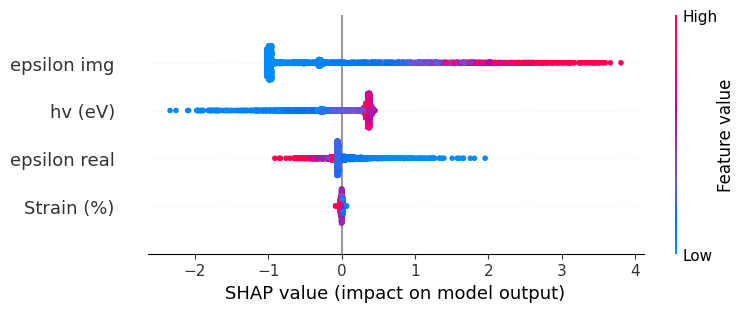

In [80]:
# @title Step NN4: Explainable Analysis
best_model = nn_model

# Select background data for SHAP (e.g., 100 samples from training set)
background = X_train.sample(100, random_state=42)

# Create SHAP explainer for your neural network model
explainer = shap.Explainer(best_model.predict, background)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Generate beeswarm summary plot
ax = shap.plots.beeswarm(shap_values, show=False)

# Get the figure from the Axes object
fig = ax.figure

# Save the figure
fig.savefig("NN_shap_summary_plot.png", dpi=600, bbox_inches='tight')